# Agent Neo: Graph Exploratory Data Analysis
*Last Updated 3 October 2023*

# Notebook Description
In this notebook we will analyze the grounding data for the Agent Neo LLM application. As part of this, we will also leverage the PaLM 2 family of models available on GCP.

Note: This is not a notebook designed to be copied and run as-is. Rather, it details several aspects of analyzing the source context documents, grounding database, and LLM conversations as implemented for Agent Neo. Effort has been made to explain and document the code, and you are encouraged to adapt the overall code and workflow for your grounded LLM application. 

# Import Libraries

In [43]:
# core libraries
import os
import time
import logging
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

import json
import seaborn as sns
import matplotlib.pyplot as plt

In [173]:
# libraries to display GCP LLM output 
from IPython.display import Markdown, display

In [44]:
# gcp and vertex AI 
from google.cloud import aiplatform
import vertexai
from vertexai.preview.language_models import TextGenerationModel, ChatModel, CodeGenerationModel, CodeChatModel

In [45]:
# library to protect secrets
import getpass

In [46]:
# install or import Neo4j GraphDataScience library
try: 
  from graphdatascience import GraphDataScience
  print('Successfully imported GraphDataScience')
except ModuleNotFoundError:
  !pip install graphdatascience
  from graphdatascience import GraphDataScience
  print('installed and imported GraphDataScience')

Successfully imported GraphDataScience


In [47]:
# limit warnings 
import warnings
warnings.filterwarnings("ignore")

# Connect to Agent Neo AuraDS Instance
We will use getpass below to protect connection and authentication details.

In [48]:
# AuraDS host link 
HOST = getpass.getpass()

In [ ]:
# AuraDS database username 
USERNAME = getpass.getpass()

In [49]:
# AuraDS password
NEO4J_PASSWORD = getpass.getpass()

 ········


In [51]:
# connect to AuraDS and confirm connection via GDS version 
gds = GraphDataScience(HOST, auth=(USERNAME, NEO4J_PASSWORD), aura_ds=True)
print('Neo4j GDS Version:', gds.version())

Neo4j GDS Version: 2.4.6+34


# Conect and Authenticate to GCP
This will enable us to access GDS resources, including the PaLM 2 LLM models.

In [52]:
# set GCP project id
PROJECT_ID = getpass.getpass()

In [53]:
# set GCP region 
REGION = getpass.getpass()

In [54]:
# initialize vertexai wth ID and region 
vertexai.init(project=PROJECT_ID, location=REGION)

In [55]:
# run the below in the jupyter terminal to authenticate your google account
# ! gcloud auth login

In [56]:
! gcloud config set project {PROJECT_ID}

Updated property [core/project].


# Instantiate LLM Models
In the following section we will instantiate and test four types of GCP PaLM 2 models, each of which is fine-tuned for a specific task:
* Text Generation
* Text Chat
* Code Generation
* Code Chat
All four of the modesl we instantiate will be the most recent versions, as of Google Next 2023 in August 2023. 

Throughout this notebook we will experiment with these speciality models to see how they perform in different situations. 

In [177]:
# function to print markdown returned by GCP models
def print_markdown(string):
    display(Markdown(string))

## Text Bison 32k Text Generation Model
[Link to documentation](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/text)

*The text-bison foundation model is optimized for a variety of natural language tasks such as sentiment analysis, entity extraction, and content creation. The types of content that the text-bison model can create include document summaries, answers to questions, and labels that classify content.*

In [57]:
# instantiate a model object
textGen_model = TextGenerationModel.from_pretrained("text-bison-32k")

In [58]:
# create a parameter dictionary 
textGen_parameters = {
    "temperature": 0.2,  # default is 0.0; 0.2 is a recommended start
    "max_output_tokens": 8192,  
    "top_p": 0.8,  
    "top_k": 40,  
}

In [59]:
# test the model with a response 
textGen_response = textGen_model.predict(
    """
    Create a concise summary of the following text:
    
    HashGNN is a node embedding algorithm which resembles Graph Neural Networks (GNN) but does not include a model or require training. 
    The neural networks of GNNs are replaced by random hash functions, in the flavor of the min-hash locality sensitive hashing. 
    Thus, HashGNN combines ideas of GNNs and fast randomized algorithms.

    The GDS implementation of HashGNN is based on the paper "Hashing-Accelerated Graph Neural Networks for Link Prediction", and further introduces 
    a few improvements and generalizations. The generalizations include support for embedding heterogeneous graphs; relationships of different types 
    are associated with different hash functions, which allows for preserving relationship-typed graph topology. Moreover, a way to specify how much 
    embeddings are updated using features from neighboring nodes versus features from the same node can be configured via neighborInfluence.

    The runtime of this algorithm is significantly lower than that of GNNs in general, but can still give comparable embedding quality for certain graphs 
    as shown in the original paper. Moreover, the heterogeneous generalization also gives comparable results when compared to the paper "Graph Transformer 
    Networks" when benchmarked on the same datasets.
    """,
    **textGen_parameters
)

print_markdown(textGen_response.text)

 HashGNN is a node embedding algorithm that resembles Graph Neural Networks (GNNs) but does not include a model or require training. 
    It replaces the neural networks of GNNs with random hash functions, resulting in significantly lower runtime while still providing comparable embedding quality for certain graphs. 
    The GDS implementation of HashGNN supports embedding heterogeneous graphs and relationships of different types, and allows for configuring how much embeddings are updated using features from neighboring nodes versus features from the same node.


## Chat Bison 32k Chat Model
[Link to documentation](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/text-chat)

*The chat-bison foundation model is a large language model (LLM) that excels at language understanding, language generation, and conversations. This chat model is fine-tuned to conduct natural multi-turn conversations, and is ideal for text tasks about code that require back-and-forth interactions.*

In [60]:
# instantiate the model object
textChat_model = ChatModel.from_pretrained("chat-bison-32k")

In [89]:
# create a parameter dictionary 
textChat_parameters = {
    "temperature": 0.2,  # default is 0.0; 0.2 is a recommended start
    "max_output_tokens": 8192,  
    "top_p": 0.8,  
    "top_k": 40,  
}

In [62]:
# start chat with a context prompt
textChat_obj = textChat_model.start_chat(
    context="You are an astronomer, knowledgeable about the solar system."
)

In [63]:
# initial question 
textChat_response = textChat_obj.send_message(
    message = "Which planet in the solar system has the most moons?", 
    **textChat_parameters)

print(textChat_response.text)

 Saturn has the most moons in the solar system, with 82 known moons as of 2023.


In [64]:
# view conversation history 
textChat_obj.message_history

[ChatMessage(content='Which planet in the solar system has the most moons?', author='user'),
 ChatMessage(content=' Saturn has the most moons in the solar system, with 82 known moons as of 2023.', author='bot')]

In [65]:
# follow-up question that references the initial response 
textChat_response = textChat_obj.send_message(
    message = "How big is its biggest moon, compared to Earth's moon?", 
    **textChat_parameters)

print(textChat_response.text)

 Saturn's largest moon, Titan, is significantly larger than Earth's moon. Titan has a diameter of 5,150 kilometers (3,200 miles), which is about 50% larger than Earth's moon, which has a diameter of 3,474 kilometers (2,159 miles). Titan is also more massive than Earth's moon, with a mass of 1.345 × 10^23 kilograms, which is about 80% more massive than Earth's moon, which has a mass of 7.347 × 10^22 kilograms.


## Code Bison 32k Code Generation Model
[Link to documentation](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/code-generation)

*code-bison is a foundation model that generates code based, including functions, web pages, and unit tests, based upon a natural language description. This model is ideal for interactions that require a single interaction with the model, as compared to the chat version specified below.* 

In [178]:
# instantiate a model object
codeGen_model = CodeGenerationModel.from_pretrained("code-bison-32k")

In [179]:
# create a parameter dictionary 
codeGen_parameters = {
    "temperature": 0.2, # same as the default value 
    "max_output_tokens": 8192
}

In [180]:
# request a function from a natural language prompt 
codeGen_response = codeGen_model.predict(
                        prefix = """Create a Python function that converts celcius temperatures 
                                    to farenheit temperatures with Google-sytle documentation.""", 
                        **codeGen_parameters
                    )

print_markdown(codeGen_response.text)

```python
def celcius_to_fahrenheit(celsius: float) -> float:
    """Converts a temperature in Celsius to Fahrenheit.

    Args:
        celsius: The temperature in Celsius.

    Returns:
        The temperature in Fahrenheit.
    """

    fahrenheit = (celsius * 9/5) + 32
    return fahrenheit
```

## CodeChat Bison 32k Code Chat Model
[Link to documentation](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/code-chat)

*codechat-bison is a foundation model that supports multi-turn conversations that are specialized for code. The model allows developers to chat with a chatbot for help with code-related questions. The code chat API is ideal for code tasks that are completed with back-and-forth interactions so you can engage in a continuous conversation.*

In [181]:
# instantiate the codechat model object
codeChat_model = CodeChatModel.from_pretrained('codechat-bison-32k')

In [182]:
# create a parameter object 
codeChat_parameters = {
        "temperature": 0.2, # same as the default value
        "max_output_tokens": 8192
}

In [183]:
# start a chat
codeChat_obj = codeChat_model.start_chat()

In [185]:
# submit first request to create a function 
codeChat_response = codeChat_obj.send_message(
    """Create a Python function that converts celcius temperatures 
        to farenheit temperatures.""", 
    **codeChat_parameters
)  

print_markdown(codeChat_response.text)

 ```python
def celcius_to_fahrenheit(celsius):
  """Converts a temperature in Celsius to Fahrenheit."""
  fahrenheit = (celsius * 9/5) + 32
  return fahrenheit
```

In [186]:
# view the chat history 
codeChat_obj.message_history

[ChatMessage(content='Create a Python function that converts celcius temperatures \n        to farenheit temperatures.', author='user'),
 ChatMessage(content=' ```python\ndef celcius_to_fahrenheit(celsius):\n  """Converts a temperature in Celsius to Fahrenheit."""\n  fahrenheit = (celsius * 9/5) + 32\n  return fahrenheit\n```', author='bot'),
 ChatMessage(content='Create a Python function that converts celcius temperatures \n        to farenheit temperatures.', author='user'),
 ChatMessage(content=' ```python\ndef celcius_to_fahrenheit(celsius):\r\n  """Converts a temperature in Celsius to Fahrenheit."""\r\n  fahrenheit = (celsius * 9/5) + 32\r\n  return fahrenheit\r\n```', author='bot')]

In [187]:
# make a second request, referencing the first 
codeChat_response = codeChat_obj.send_message(
    """Update the function to include Google-style documentation.""", 
    **codeChat_parameters
) 

print_markdown(codeChat_response.text)

 ```python
def celcius_to_fahrenheit(celsius):
  """Converts a temperature in Celsius to Fahrenheit.

  Args:
    celsius: The temperature in Celsius.

  Returns:
    The temperature in Fahrenheit.
  """
  fahrenheit = (celsius * 9/5) + 32
  return fahrenheit
```

# Neo4j Database Overview
We have already loaded our context data and started logging LLM conversations with Agent Neo. A description of the graph data model is available in our Nodes 2023 slides.

## Database Overview

In [326]:
# call apoc.meta.stats() to get a summary of the graph
apoc_stats = gds.run_cypher("CALL apoc.meta.stats()")

In [327]:
# view sleceted fields
apoc_stats[['nodeCount', 'labelCount', 'relCount', 'relTypeCount']]

,nodeCount,labelCount,relCount,relTypeCount
0,15984,5,377691,6


## Node Counts

In [329]:
# parse nodetype and count into dataframe 
nodeType_counts = pd.DataFrame(apoc_stats['labels'][0].items(), columns=['nodeType', 'count']).sort_values(by='count', ascending=False)
nodeType_counts

,nodeType,count
1,Document,14476
4,URL,1157
2,Message,275
0,Conversation,44
3,Session,32


## Relationship Counts

In [193]:
relationshipType_counts = pd.DataFrame(apoc_stats['relTypesCount'][0].items(), columns=['relType', 'count']).sort_values(by='count', ascending=False)
relationshipType_counts = relationshipType_counts.set_index(['relType'])

print('Total count of relationships with labels:', relationshipType_counts['count'].sum())

Total count of relationships with labels: 15791


In [194]:
relationshipType_counts

,count
relType,
HAS_SOURCE,14476
HAS_CONTEXT,996
NEXT,231
HAS_CONVERSATION,44
FIRST,44


# Download Context Data from Neo4j
We will query the graph database for the context loaded into Neo4j. If you are combining context from multiple data types and sources, pulling it straight from the Neo4j database can be more straightforward than combining multiple tables or dataframes in Python. The best approach, however, will always depend on the given situation. 

In [85]:
# download context and source URLs into a dataframe 
context_df = gds.run_cypher('''
MATCH (d:Document)
RETURN
    d.index AS index,
    d.url AS url,
    d.text AS text
''')

context_df.shape

(14476, 3)

In [86]:
context_df.head()

,index,url,text
0,6430,https://neo4j.com/docs/cypher-manual/current/syntax/expressions/,"For numerical values passed in as parameters, Cypher does not take the size of the number into account. Cypher will therefore regard any exact numerical parameter as an INTEGER regardless of its declared size. For example, an INT16 or an INT32 passed through from a client programming language will both be treated by Cypher as an INTEGER. Note that any exact numerical parameter used must fit within the range of an INT 64. true Rows: 1 More information about parameters can be found here."
1,0,https://neo4j.com/docs/graph-data-science/current/management-ops/projections/graph-project-cypher-legacy/,"Projecting graphs using Cypher (deprecated) This page describes the Legacy Cypher projection, which is deprecated. The replacement is to use the new Cypher projection, which is described in Projecting graphs using Cypher. A migration guide is available at Appendix C, Migration from Legacy to new Cypher projection."
2,1,https://neo4j.com/docs/graph-data-science/current/management-ops/projections/graph-project-cypher-legacy/,Using Legacy Cypher projections is a more flexible and expressive approach with diminished focus on performance compared to the native projections. Legacy Cypher projections are primarily recommended for the development phase (see Common usage). 1. Considerations 1.1. Lifecycle The projected graphs will reside in the catalog until either: the graph is dropped using gds.graph.drop the Neo4j database from which the graph was projected is stopped or dropped
3,2,https://neo4j.com/docs/graph-data-science/current/management-ops/projections/graph-project-cypher-legacy/,the Neo4j database management system is stopped. 1.2. Node property support Legacy Cypher projections can only project a limited set of node property types from a Cypher query. The Node Properties page details which node property types are supported. Other types of node properties have to be transformed or encoded into one of the supported types in order to be projected using a Legacy Cypher projection. 2. Syntax
4,3,https://neo4j.com/docs/graph-data-science/current/management-ops/projections/graph-project-cypher-legacy/,"2. Syntax A Legacy Cypher projection takes three mandatory arguments: graphName, nodeQuery and relationshipQuery. In addition, the optional configuration parameter allows us to further configure graph creation. graphName no The name under which the graph is stored in the catalog. nodeQuery no Cypher query to project nodes. The query result must contain an id column. Optionally, a labels column can be specified to represent node labels. Additional columns are interpreted as properties."


# Ask LLM for Guidance Analyzing Text and URLs
We will start by asking the ChatBison for guidance about performing EDA on the context data. We will use the chat model because we may want to request additional or follow-up information from the response, so we want it to have the conversation history saved. 

In [217]:
# start a new chat to ask about analyzing this dataframe 
textChat_obj = textChat_model.start_chat(
    context="You are a data scientist with extensive natrual language processing experience."
)

In [218]:
prompt = f"""
I have a 14,500 row pandas DataFrame with the following features:
'url', string, which is the URL for the source document;
'text', string, which is a text portion of technical documentation or a technical blog post;

I already performed preliminary data cleaning and preprocessing on the text. 
This text has been loaded into a Neo4j graph database, along with embeddings of the text, for use with a 
document augmented retrieval-augmented large language model application.

First, I want you to suggest statistical features I can create to better understand the text chunks and URLs right now. 
These could also be useful features that I load into the graph data model to enhance the grounding or better 
analyze the text in graph format. Provide suggestions for what analysis I could perform.
"""

textChat_response = textChat_obj.send_message(prompt, **textChat_parameters)

print_markdown(textChat_response.text)

 Here are some statistical features that you can create to better understand the text chunks and URLs in your pandas DataFrame:

* **Text length:** The number of words or characters in each text chunk.
* **Number of sentences:** The number of sentences in each text chunk.
* **Average sentence length:** The average number of words per sentence in each text chunk.
* **Lexical diversity:** The number of unique words in each text chunk divided by the total number of words in the text chunk.
* **Semantic similarity:** The cosine similarity between the embeddings of each text chunk.
* **URL length:** The number of characters in each URL.
* **Number of path components:** The number of components in the path of each URL.
* **Top-level domain:** The top-level domain of each URL.
* **URL entropy:** The entropy of the distribution of characters in each URL.

You can use these features to perform a variety of analyses on your text chunks and URLs. For example, you could:

* Cluster the text chunks based on their semantic similarity.
* Identify the most important words and phrases in each text chunk.
* Find the most common URLs in your dataset.
* Identify the most authoritative websites in your dataset.
* Track the evolution of the text chunks and URLs over time.

# Perform Text Analysis

## Text Character Length
We specified a 512 character length chunk size due to the fact that we were initially working with LLMs that had much shorter context lengths. However, not all the chunks are exactly this length due to the underlying text and impact of different separators. Note: This is a character length, not a word or token count length.

In [92]:
# create a text length feature
context_df['text_len'] = context_df['text'].apply(len)

In [219]:
# statistical distribution
charLen_dist = context_df['text_len'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]).round()
charLen_dist

count    14476.0
mean       402.0
std        112.0
min          1.0
25%        357.0
50%        445.0
75%        483.0
90%        499.0
95%        506.0
99%        511.0
99.9%      512.0
max        512.0
Name: text_len, dtype: float64

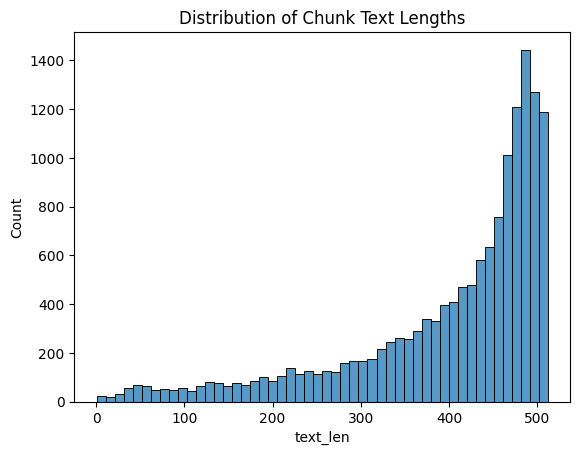

In [100]:
# visualize distribution 
sns.histplot(data=context_df, x='text_len')
plt.title('Distribution of Chunk Text Lengths')
plt.show()

In [220]:
# ask ChatBison for its interpretation of the text length distribution 
prompt = f"""
The distribution of text string character lengths in my data
is the following: {charLen_dist}

How should I interpret this in the context of evaluating the text
chunks to ground a chat assistant built upon a large language model?
"""

textChat_response = textChat_obj.send_message(prompt, **textChat_parameters)

print_markdown(textChat_response.text)

 The distribution of text string character lengths in your data shows that the majority of the text chunks are between 357 and 483 characters long. This suggests that the text chunks are relatively short, which could make them easier to process and analyze. However, there are also a small number of text chunks that are much longer, which could pose a challenge for processing and analysis.

In the context of evaluating the text chunks to ground a chat assistant built upon a large language model, the distribution of text string character lengths could be used to inform the design of the chat assistant. For example, the chat assistant could be designed to handle shorter text chunks more efficiently, or it could be designed to handle longer text chunks by breaking them down into smaller chunks.

Additionally, the distribution of text string character lengths could be used to evaluate the performance of the chat assistant. For example, the chat assistant could be evaluated on its ability to accurately respond to questions that are based on short text chunks, and it could be evaluated on its ability to accurately respond to questions that are based on long text chunks.

## Text Word Count
We will also calculate the word count of each text chunk because it can potentially identify outliers in the data. 

In [96]:
# create word count feature 
context_df['word_count'] = context_df['text'].str.split().apply(len)

In [212]:
# calculate statistical distribution
wordCount_dist = context_df['word_count'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]).round()
wordCount_dist

count    14476.0
mean        56.0
std         21.0
min          1.0
25%         44.0
50%         62.0
75%         72.0
90%         79.0
95%         83.0
99%         88.0
99.9%       95.0
max        105.0
Name: word_count, dtype: float64

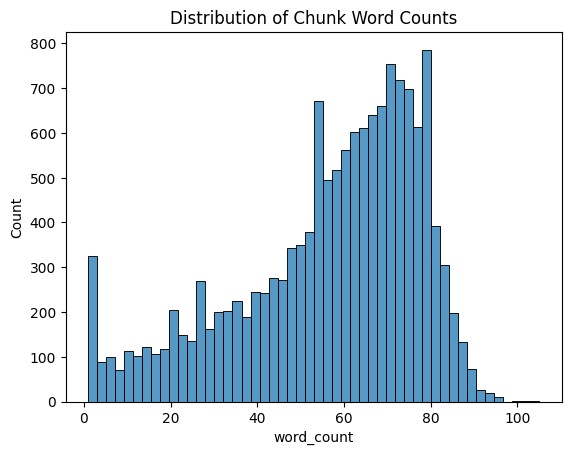

In [109]:
# plot distribution 
sns.histplot(data=context_df, x='word_count', bins=50)
plt.title('Distribution of Chunk Word Counts')
plt.show()

In [222]:
prompt = f"""
In the same dataframe, the word count distribution among the text strings 
in my data is the following: {wordCount_dist}

How should I interpret this data, combined with the word count data from before,
as I evaluate the text chunks? As I mentioned, they are stored in a Neo4j 
graph database to use as context for a large language model chat agent.
"""

textChat_response = textChat_obj.send_message(prompt, **textChat_parameters)

print_markdown(textChat_response.text)

 The distribution of word counts in your data shows that the majority of the text chunks are between 44 and 72 words long. This suggests that the text chunks are relatively short, which could make them easier to process and analyze. However, there are also a small number of text chunks that are much longer, which could pose a challenge for processing and analysis.

When combined with the distribution of text string character lengths, this data suggests that the text chunks are relatively short and easy to process. This could be beneficial for a large language model chat agent, as it would be able to process the text chunks quickly and efficiently. However, the presence of a small number of long text chunks could pose a challenge for the chat agent, as it might not be able to process them as quickly or efficiently.

To address this challenge, the chat agent could be designed to handle longer text chunks by breaking them down into smaller chunks. This would allow the chat agent to process the text chunks more quickly and efficiently, while still maintaining the ability to handle longer text chunks.

Additionally, the distribution of word counts could be used to evaluate the performance of the chat agent. For example, the chat agent could be evaluated on its ability to accurately respond to questions that are based on short text chunks, and it could be evaluated on its ability to accurately respond to questions that are based on long text chunks.

## Text Average Word Length
We want to calculate the average word length, but to do so will ask the PaLM2 Code Gen model for help writing the code to do so in Python with a pandas DataFrame. 

In [201]:
prompt = """
I have a 14,500 row pandas DataFrame with the following features:
'url', string, which is the URL for the source document;
'text', string, which is a text portion of technical documentation or a technical blog post;

I want to calculate the average word length, rounded to two decimal points,
for each piece of text as a new feature in my DataFrame. 
Please provide me with the code to do this.
"""

# request a function from a natural language prompt 
codeGen_response = codeGen_model.predict(prefix = prompt, **codeGen_parameters)

print_markdown(codeGen_response.text)

```python
import pandas as pd

# Load the data
df = pd.read_csv('data.csv')

# Calculate the average word length for each piece of text
df['avg_word_length'] = df['text'].apply(lambda x: round(sum(len(word) for word in x.split()) / len(x.split()), 2))
```

In [115]:
# implement the provided code 
context_df['avg_word_len'] = context_df['text'].apply(lambda x: round(np.mean([len(word) for word in x.split()]), 2))

In [215]:
# calculate statistical distribution
avgWordLen_dist = context_df['avg_word_len'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]).round()
avgWordLen_dist

count    14476.0
mean        13.0
std         54.0
min          1.0
25%          5.0
50%          6.0
75%          7.0
90%          9.0
95%         13.0
99%        511.0
99.9%      512.0
max        512.0
Name: avg_word_len, dtype: float64

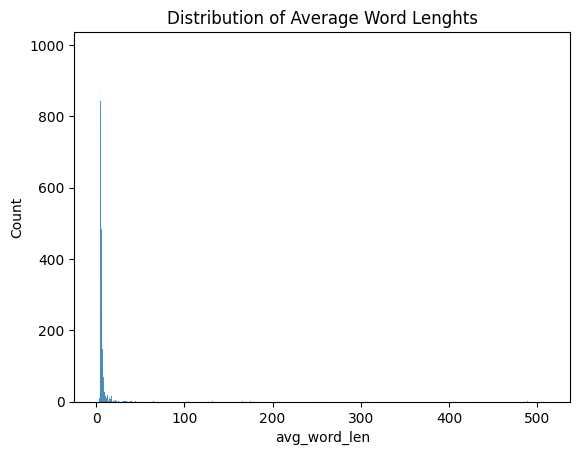

In [120]:
# plot word length distribution 
sns.histplot(data=context_df, x='avg_word_len')
plt.title('Distribution of Average Word Lenghts')
plt.show()

In [223]:
prompt = f"""
In the same dataframe, the word length distribution among the text strings 
in my data is the following: {avgWordLen_dist}

Combined with the character lenghts and word counts, how should I use the average
word lenghts to evaluate the text chunks for grounding? Additionally, how can I use all
of this text information to evaluate both the text and the performance of the large
language model chat agent?
"""

textChat_response = textChat_obj.send_message(prompt, **textChat_parameters)

print_markdown(textChat_response.text)

 The distribution of average word lengths in your data shows that the majority of the words in the text chunks are between 5 and 7 characters long. This suggests that the words in the text chunks are relatively short, which could make them easier to process and analyze. However, there are also a small number of words that are much longer, which could pose a challenge for processing and analysis.

When combined with the distribution of text string character lengths and word counts, this data suggests that the text chunks are relatively short and easy to process. This could be beneficial for a large language model chat agent, as it would be able to process the text chunks quickly and efficiently. However, the presence of a small number of long words could pose a challenge for the chat agent, as it might not be able to process them as quickly or efficiently.

To address this challenge, the chat agent could be designed to handle longer words by breaking them down into smaller chunks. This would allow the chat agent to process the words more quickly and efficiently, while still maintaining the ability to handle longer words.

Additionally, the distribution of average word lengths could be used to evaluate the performance of the chat agent. For example, the chat agent could be evaluated on its ability to accurately respond to questions that are based on words that are of average length, and it could be evaluated on its ability to accurately respond to questions that are based on words that are longer than average.

Here are some specific ways that you can use the text information to evaluate both the text and the performance of the large language model chat agent:

* **Use the text information to evaluate the quality of the text chunks.** You can use the text information to evaluate the quality of the text chunks by looking at the following factors:
    * **The length of the text chunks.** The text chunks should be long enough to provide sufficient context for the chat agent to answer questions accurately. However, they should not be so long that they are difficult for the chat agent to process.
    * **The complexity of the text chunks.** The text chunks should be complex enough to challenge the chat agent. However, they should not be so complex that they are difficult for the chat agent to understand.
    * **The relevance of the text chunks.** The text chunks should be relevant to the topics that the chat agent is expected to answer questions about.
* **Use the text information to evaluate the performance of the chat agent.** You can use the text information to evaluate the performance of the chat agent by looking at the following factors:
    * **The accuracy of the chat agent's responses.** The chat agent should be able to answer questions accurately based on the information in the text chunks.
    * **The speed of the chat agent's responses.** The chat agent should be able to answer questions quickly.
    * **The user-friendliness of the chat agent.** The chat agent should be easy for users to interact with.

## URL Frequency
All of our grounding source documents come from public URLs, so we can analyze the HAS_SOURCE relationships in our graph to quickly see which pages provided the largest number of text chunks.

In [121]:
print('unique count of urls:', context_df['url'].nunique())

unique count of urls: 1157


In [226]:
# calculate the distribution of URLs as sources to text chunks
url_dist = context_df['url'].value_counts().describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]).round()

print('Distribution of URLs:')
url_dist

Distribution of URLs:


count    1157.0
mean       13.0
std        20.0
min         1.0
25%         2.0
50%         4.0
75%        15.0
90%        36.0
95%        52.0
99%        87.0
99.9%     184.0
max       286.0
Name: url, dtype: float64

In [122]:
print('top 20 most frequent URLs as text chunk sources:')
context_df['url'].value_counts().head(20)

top 20 most frequent URLs as text chunk sources:


https://neo4j.com/docs/operations-manual/current/configuration/configuration-settings/             286
https://neo4j.com/docs/apoc/current/overview/                                                      191
https://neo4j.com/docs/cypher-manual/current/functions/temporal/                                   144
https://neo4j.com/docs/cypher-manual/current/deprecations-additions-removals-compatibility/        124
https://neo4j.com/docs/aura/platform/apoc/                                                         102
https://neo4j.com/docs/cypher-manual/current/administration/access-control/dbms-administration/    100
https://neo4j.com/docs/apoc/current/graph-querying/expand-paths-config/                             97
https://neo4j.com/docs/apoc/current/overview/apoc.path/apoc.path.expandConfig/                      95
https://neo4j.com/docs/cypher-manual/current/constraints/examples/                                  94
https://neo4j.com/docs/cypher-manual/current/execution-plans/operators/  

In [127]:
print('bottom 10 URLs as text chunk sources:')
context_df['url'].value_counts().tail(10)

bottom 10 URLs as text chunk sources:


https://neo4j.com/docs/apoc/current/overview/apoc.coll/apoc.coll.zipToRows/            1
https://neo4j.com/docs/apoc/current/overview/apoc.periodic/apoc.periodic.list/         1
https://neo4j.com/docs/apoc/current/overview/apoc.node/apoc.node.degree.out/           1
https://neo4j.com/docs/apoc/current/overview/apoc.convert/apoc.convert.toMap/          1
https://neo4j.com/docs/apoc/current/overview/apoc.node/apoc.node.degree/               1
https://neo4j.com/docs/apoc/current/overview/apoc/apoc.when/                           1
https://neo4j.com/docs/graph-data-science/current/common-usage/projecting-graphs/      1
https://neo4j.com/docs/graph-data-science/current/installation/installation-docker/    1
https://neo4j.com/docs/apoc/current/overview/apoc.math/apoc.math.sinh/                 1
https://neo4j.com/docs/apoc/current/overview/apoc.math/apoc.math.sigmoid/              1
Name: url, dtype: int64

# Graph EDA
After exploring the text chunks (Document nodes), we will turn our focus to exploring the graph and using Graph Data Science algorithms to create graph features.

## Ask LLM for Guidance
While we might have ideas for how to analyze this graph, it does not hurt to provide details to the LLM and ask for its advice as well.

In [228]:
# start a new chat 
textChat_obj = textChat_model.start_chat(
    context="You are an experienced, helpful graph data scientist who works at Neo4j."
)

In [229]:
prompt = f"""
I have a Neo4j graph with the following schema:
(d:Document)-[:HAS_SOURCE]->(u:URL)

The Document nodes will be used to provide grounding to a chat agent
powered by a large language model. Each ndoe has the following properties:
d.text: a portion of text from a technical document, with the maximum length of 512 characters
d.url: the URL from which the technical text segment originated
d.embedding: a 768 length vector embedding of the text

The URL nodes have the following property:
url: the URL of the page, which matches the connected d.url property on 
Document nodes

The d.text character lengths have the following distribution: 
charLen_dist

The the d.text to URL associations have the following frequencies, 
represented as [:HAS_SOURCE] relationships: 
url_dist

Provide suggestions for how to analyze this graph in the context of using it
for LLM grounding. What Graph Data Science algorithms and workflow may be
the most insightful?
"""

textChat_response = textChat_obj.send_message(prompt, **textChat_parameters)

print_markdown(textChat_response.text)

 Here are some suggestions for how to analyze your graph in the context of using it for LLM grounding:

* **Identify the most important documents.** You can use the `d.embedding` property to identify the documents that are most similar to each other. These documents are likely to be the most relevant for grounding the LLM.
* **Identify the most important URLs.** You can use the `url_dist` property to identify the URLs that are most frequently associated with documents. These URLs are likely to be the most important for grounding the LLM.
* **Create a graph of the most important documents and URLs.** You can use the `d.embedding` and `url_dist` properties to create a graph of the most important documents and URLs. This graph can be used to visualize the relationships between the documents and URLs, and to identify clusters of related documents and URLs.
* **Use graph algorithms to analyze the graph.** You can use graph algorithms to analyze the graph of the most important documents and URLs. For example, you can use the following algorithms:
    * **PageRank:** PageRank can be used to identify the most important documents and URLs in the graph.
    * **Clustering:** Clustering can be used to identify clusters of related documents and URLs in the graph.
    * **Shortest paths:** Shortest paths can be used to find the shortest paths between documents and URLs in the graph.

These are just a few suggestions for how to analyze your graph in the context of using it for LLM grounding. There are many other possible approaches, and the best approach will depend on your specific needs and requirements.

### Graph Maintenance
Option code in case we need to make changes to the graph database.

In [230]:
# # code to delete existing or prior relationships, if necessary
# gds.run_cypher('''
# MATCH ()-[r:SIMILARITY]->() 
# CALL { WITH r 
# DELETE r
# } IN TRANSACTIONS OF 50000 ROWS
# ''')

In [136]:
# # code to drop an existing projection
# gds.run_cypher('''
# CALL gds.graph.drop('')
# ''')

In [137]:
# list any graph projections stored in memory 
gds.run_cypher('''
CALL gds.graph.list()
''')

,degreeDistribution,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema,schemaWithOrientation


## Create K-Nearest Neighbors Similarity Graph
First we create a placeholder relationship because creating a graph projection requires that a relationship type be passed. Creating the 'EMPTY' relationship allows us to do this without passing any actual relationships, which KNN would not use anyways.

In [138]:
# create empty relationship type
gds.run_cypher("""
CALL db.createRelationshipType('EMPTY')
""")

""


## Create Graph Projection
We will project Document nodes with the 'embedding' property into memory. We also specify the 'EMPTY' relationship, though none of these actually exist.

In [142]:
g, _ = gds.graph.project(
    graph_name = 'docs',
    node_spec = ['Document'],
    nodeProperties = ['embedding'],
    relationship_spec = 'EMPTY'
)

## Explore KNN Statistics In-Memory

### KNN Statistics
Before running KNN either in mutate or write mode, we can explore the distributions from different topK values to determine which to select.

In [235]:
_ = gds.knn.stats(G = g,
                  topK=25,
                  nodeProperties=['embedding'],
                  concurrency=2
)

pd.DataFrame(_)[0]['similarityDistribution']

{'min': 0.868743896484375,
 'p5': 0.9138336181640625,
 'max': 1.0000038146972656,
 'p99': 0.99609375,
 'p1': 0.9022178649902344,
 'p10': 0.9195976257324219,
 'p90': 0.9724578857421875,
 'p50': 0.9414100646972656,
 'p25': 0.9291610717773438,
 'p75': 0.9567222595214844,
 'p95': 0.9832038879394531,
 'mean': 0.943806810276256,
 'p100': 1.0000038146972656,
 'stdDev': 0.020605579542907648}

In [236]:
# ask ChatBison for its interpretation of the topK = 25 similarity distribution 
prompt = f"""
In the same graph I am using K-nearest neighbors to calculate similarity relationships among 
the Document nodes based upon the d.embedding feature. I created 25 relationships for each 
Document node, connecting it to its most similar neighbors. 

Help me interpret and draw conclusions from the following similarity distribution 
of the newly-created relationships: {pd.DataFrame(_)[0]['similarityDistribution']}
"""

textChat_response = textChat_obj.send_message(prompt, **textChat_parameters)

print_markdown(textChat_response.text)

 The similarity distribution of the newly-created relationships shows that the majority of the relationships are very strong, with similarities above 0.9. This suggests that the K-nearest neighbors algorithm is doing a good job of finding similar documents. 

There are a few outliers with similarities below 0.9, which could be due to noise in the data or to the fact that the K-nearest neighbors algorithm is not perfect. However, these outliers do not significantly affect the overall distribution.

The p50 value of 0.9414100646972656 indicates that half of the relationships have a similarity of at least 0.9414100646972656. This is a high similarity threshold, which suggests that the documents in the graph are very similar to each other.

The p95 value of 0.9832038879394531 indicates that 95% of the relationships have a similarity of at least 0.9832038879394531. This is an even higher similarity threshold, which suggests that the documents in the graph are very similar to each other.

Overall, the similarity distribution of the newly-created relationships shows that the documents in the graph are very similar to each other. This is a good sign for using the graph for LLM grounding, as it means that the LLM will have a lot of similar documents to choose from when generating text.

### Create KNN Relationships In-Memory
First we will run KNN in mutate mode so that only the in-memory graph projection is changed. We can choose to write these relationships to the graph later, but that is optional. In some cases, KNN with a high topK and large volume of nodes can result in hundreds of millions of relationships being written to the graph, which we may want to avoid.

In [151]:
_ = gds.knn.mutate(G = g,
                  topK = 25,
                  nodeProperties = ['embedding'],
                  mutateRelationshipType = "SIMILARITY",
                  mutateProperty = "score"
)

Knn:   0%|          | 0/100 [00:00<?, ?%/s]

### Label Propagation (LPA) in Stats Mode
We commonly use LPA when detecting communities on a similarity graph. Often, there is an inverse relationship between the topK number of relationships and the communities detected by LPA. Therefore, part of evaluating the topK to select can be running LPA afterwards to see the resulting number of communities. 

In [237]:
# run LPA in stats mode and catch output 
_ = gds.labelPropagation.stats(G = g, 
                               relationshipTypes = ['SIMILARITY'],
                               relationshipWeightProperty = 'score')

In [239]:
# display communityCount and communityDistribution 
pd.DataFrame(_)[0][['communityCount', 'communityDistribution']]

communityCount                                                                                                                     160
communityDistribution    {'min': 9, 'max': 854, 'p90': 172, 'p999': 854, 'p99': 726, 'p50': 48, 'p75': 94, 'p95': 279, 'mean': 90.475}
Name: 0, dtype: object

We performed other KNN and LPA experiements, not shown here.

With 10 similarity relationships we identified: 
* communityCount: 575
* communityDistribution: 
    * 'min': 3
    * 'p50': 18 
    * 'mean': 25.17
    * 'p75': 30
    * 'p90': 51
    * 'p95': 72
    * 'p99': 136
    * 'p999': 316
    * 'max': 316

With 25 similarity relationships we identified:
* communityCount: 160
* communityDistribution: 
    * 'min': 9 
    * 'p50': 48
    * 'mean': 90.475
    * 'p75': 94
    * 'p90': 172
    * 'p95': 279
    * 'p99': 726
    * 'p999': 854
    * 'max': 854

In [241]:
# as with other statistics, ask ChatBison for its interpretation of the LPA distribution 
prompt = f"""
In the same graph I used Label Propagation (LPA) to identify communities among the
simiarlity relationships among Documents. The similarity score on the relationship
was used as a weight when identifying communities. 

Help me interpret and draw conclusions from the following LPA community distribution 
among the newly-created relationships: {pd.DataFrame(_)[0][['communityCount', 'communityDistribution']]}
"""

textChat_response = textChat_obj.send_message(prompt, **textChat_parameters)

print_markdown(textChat_response.text)

 The LPA community distribution shows that there are a large number of small communities and a few large communities. This suggests that the documents in the graph are not evenly distributed across the communities.

The p50 value of 48 indicates that half of the communities have 48 or fewer members. This is a relatively small number, which suggests that the majority of the communities are small.

The p95 value of 279 indicates that 95% of the communities have 279 or fewer members. This is a larger number than the p50 value, but it still suggests that the majority of the communities are small.

The p99 value of 726 indicates that 99% of the communities have 726 or fewer members. This is a large number, which suggests that there are a few large communities in the graph.

The p999 value of 854 indicates that the largest community has 854 members. This is a very large number, which suggests that there is a significant amount of overlap between the communities.

Overall, the LPA community distribution shows that the documents in the graph are not evenly distributed across the communities. There are a large number of small communities and a few large communities. This suggests that the documents in the graph are not all equally similar to each other.

### Explore Weighted PageRank
PageRank is a valuable algorithm for calculating a ndoes importance or influence within a network. When combined with LPA communities on a similarity graph, the weighted verison of PageRank, which incorporates actual similarity scores, can identify the most influential nodes in the entire graph as well as the most influential nodes within each community. This calculation is helpful when we are analyzeing the communities and looking to identify a representative node from each community. 

In [242]:
# calculate PageRank in stats mode first
_ = gds.pageRank.stats(G=g, 
                       relationshipTypes=['SIMILARITY'], 
                       relationshipWeightProperty = 'score')

In [244]:
pd.DataFrame(_)[0]['centralityDistribution']

{'min': 0.14999961853027344,
 'max': 9.153197288513184,
 'p90': 2.0926198959350586,
 'p999': 8.249693870544434,
 'p99': 5.096892356872559,
 'p50': 0.6177167892456055,
 'p75': 1.195021629333496,
 'p95': 2.780196189880371,
 'mean': 0.9612404103765306}

In [245]:
# ask ChatBison for its interpretation of the PageRank scores
prompt = f"""
In the same graph I used PageRank to calculate a centrality score for each document. 
The similarity score on the relationship was used as a weight when calculating PageRank. 

Help me interpret and draw conclusions from the following PageRank distribution 
among Documents based upon the KNN similarity relationships: {pd.DataFrame(_)[0]['centralityDistribution']}
"""

textChat_response = textChat_obj.send_message(prompt, **textChat_parameters)

print_markdown(textChat_response.text)

 The PageRank distribution shows that there is a large gap between the highest-ranked documents and the lowest-ranked documents. This suggests that there are a few documents that are much more important than the others.

The p50 value of 0.6177167892456055 indicates that half of the documents have a PageRank score of 0.6177167892456055 or less. This is a relatively low score, which suggests that the majority of the documents are not very important.

The p95 value of 2.780196189880371 indicates that 95% of the documents have a PageRank score of 2.780196189880371 or less. This is a higher score than the p50 value, but it still suggests that the majority of the documents are not very important.

The p99 value of 5.096892356872559 indicates that 99% of the documents have a PageRank score of 5.096892356872559 or less. This is a high score, which suggests that there are a few very important documents in the graph.

The p999 value of 8.249693870544434 indicates that the highest-ranked document has a PageRank score of 8.249693870544434. This is a very high score, which suggests that this document is much more important than the others.

Overall, the PageRank distribution shows that there is a large gap between the highest-ranked documents and the lowest-ranked documents. This suggests that there are a few documents that are much more important than the others.

## Write KNN, LPA, and PageRank Outputs to Graph
Once we have the KNN, LPA, and PageRank specifications that we want to use, we can write all of the results to the database. However, writing the KNN relationships is optional because with a higher topK and a larger graph, this can add tens or hundreds of millions of relationships to the database. LPA and PageRank outputs can also be streamed if not written to nodes as properties. 

In [203]:
_ = gds.knn.write(G = g,
                  topK = 25,
                  nodeProperties = ['embedding'],
                  writeRelationshipType = "SIMILARITY",
                  writeProperty = "score"
)

Knn:   0%|          | 0/100 [00:00<?, ?%/s]

In [161]:
_ = gds.labelPropagation.write(G = g, 
                               relationshipTypes = ['SIMILARITY'],
                               relationshipWeightProperty = 'score',
                               writeProperty = 'community')

In [162]:
_ = gds.pageRank.write(G=g, 
                       relationshipTypes=['SIMILARITY'], 
                       relationshipWeightProperty = 'score',
                       writeProperty='pageRank')

## Combine GDS Statistics with Context Data
After writing the GDS statistics to the graph, we will export them and merge these with our existing DataFrame using the node index for the merge. 

In [208]:
# download to new dataframe 
gds_df = gds.run_cypher('''
MATCH (d:Document)
RETURN 
    d.index AS index,
    d.community AS community,
    d.pageRank AS pageRank
''')

gds_df.shape

(14476, 3)

In [210]:
# merge gds values with context df
context_df = pd.merge(context_df, gds_df, on="index")
context_df.shape

(14476, 8)

# Analyze Context Document Communities
After identifying communities and calculating PageRank scores, we can turn our attention to further evaluating our context database to understand its details and evaluate the text chunks for quality and efficiency. 

## Distribution of LPA Community Sizes
While we saw the distribution when we created the LPA communities, we can also visualize it now that we have the exact size for each community. 

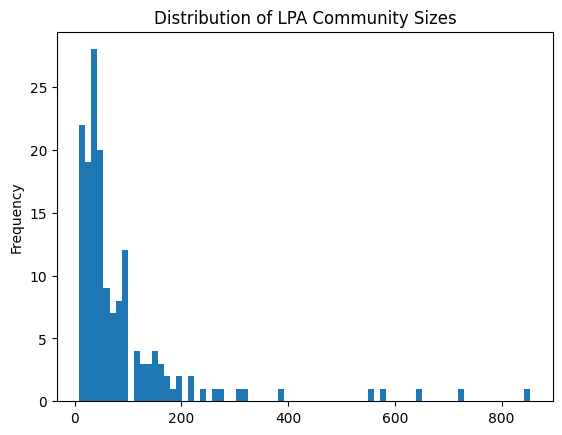

In [254]:
context_df['community'].value_counts().plot(kind='hist', bins=75)
plt.title('Distribution of LPA Community Sizes')
plt.show()

## Plot PageRank Score Distribution
We can do the same visualizing PageRank scores. 

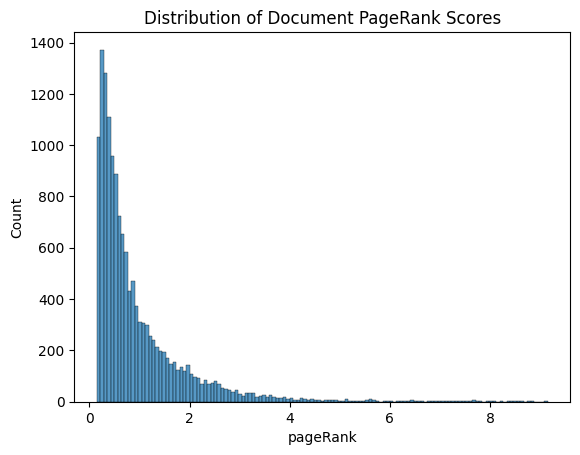

In [247]:
sns.histplot(data=context_df, x='pageRank')
plt.title('Distribution of Document PageRank Scores')
plt.show()

# Visualize Similarity Graph and Communities via Node Embeddings
To gain a big-picture view of our entire grounding data set we will generate node embeddings from the similarity graph.

In [286]:
# # list graph projections to drop if necessary 
# gds.run_cypher('''
# CALL gds.graph.list()
# ''')

### Create New Undirected Projection
First we will create a new graph projection. FastRP was designed to operate on un-directed graphs, so we will specify that the relationships in this projection are UNDIRECTED.

In [287]:
# create graph projection 
g, _ = gds.graph.project(
    graph_name = 'doc-similarity', 
    node_spec = ['Document'], 
    relationship_spec = {'SIMILARITY': {'orientation': 'UNDIRECTED'}},
    relationshipProperties = ['score'],
)

In [297]:
# confirm internal details of the projection 
print('Graph projection node count:', g.node_count())
print('Graph projection node labels', g.node_labels())
print('Graph projection relationship count:', g.relationship_count())
print('Graph projection relationship types:', g.relationship_types())
print('Graph projection density:', g.density().round(4))

Graph projection node count: 14476
Graph projection node labels ['Document']
Graph projection relationship count: 723800
Graph projection relationship types: ['SIMILARITY']
Graph projection density: 0.0035


### Generate and FastRP Embeddings and Write to Graph
The embeddings generated below will be written to the Document nodes as new properties. If you are working on a larger graph where this would take up too much memory, an alternative would be to stream them directly to a dataframe (or use a smaller embedding dimension). Running FastRP in stats mode first will help you anticipate memory requirements and output. 

We will specify the following hyperparameters for the FastRP algorithm:
* 256 dimension embeddings
* five levels of iteration, allowing the graph to 'reach out' further from each node
* capture the relationship similarity score as part of the embedding

In [293]:
# generate fastRP embeddings and write to nodes as a new property
_ = gds.fastRP.write(G=g,
                     nodeLabels=['Document'],
                     relationshipTypes=['SIMILARITY'],
                     relationshipWeightProperty='score',
                     writeProperty='fastRP_similarity',
                     embeddingDimension=256,
                     iterationWeights=[0.0, 1.0, 1.0, 0.5, 0.5], # expanding iteration weights by two from default to reach further into the graph
                     randomSeed=42)

FastRP:   0%|          | 0/100 [00:00<?, ?%/s]

### Download FastRP Embeddings with Communities and PageRank
We will create a new dataframe to use for visualizing the embeddings. We will include the LPA Community and PageRank scores as well to use as additional visualization elements. 

In [298]:
# download fastRP embeddings
doc_fastRP = gds.run_cypher('''
MATCH (d:Document)
RETURN
    d.index AS index,
    d.fastRP_similarity AS fastRP,
    d.pageRank AS pageRank,
    d.community AS community

''')

doc_fastRP.shape

(14476, 4)

In [570]:
# set community as string for plotting
doc_fastRP['community'] = doc_fastRP['community'].astype(str)

### Generate Code to Plot Embeddings in Two Dimensions
The following function will use TSNE to compress the embeddings into two dimensions then plot them via Plotly. Additionally, the plot will apply color to represent graph communities and size to represent weighted PageRank score. The purpose of this plot is to enable us to visualize the entire grounding data set and determine if the text embeddings provide meaningful differentation.

In [309]:
import plotly.express as px
from sklearn.manifold import TSNE


In [323]:
def plot_2d_embeddings(embedding_df, embeddings_col, labels_col, size_col, plot_title, width=1000, height=800):
    '''Create a 2d plot of embeddings
        Inputs:
            embedding_df: dataframe containing embeddings 
            embeddings_col: dataframe column containing embeddings as nested lists 
            labels_col: column containing label values; typically community IDs
            size_col: column containing values used to size plot objects
            plot_title: title for the plot
            width: width value for plot object; defaults to 1000
            height: height value for plot object; defaults to 800

        Returns:
            plotly object containing 2d figure
    '''
    # extract and stack embeddings values
    embeddings = np.vstack(embedding_df[embeddings_col].values)

    # instantiate T-SNE and fit to embeddings
    tsne = TSNE(n_components=2)
    embeddings_2d = tsne.fit_transform(embeddings)

    # extract labels from df 
    labels = embedding_df[labels_col].values

    # extract slizes from df
    sizes = embedding_df[size_col].values
    
    # create plot 
    embed_2d_fig = px.scatter(x=embeddings_2d[:, 0],
                            y=embeddings_2d[:, 1],
                            color=labels,
                            size=sizes,
                            labels={'x': 'Dimension 1', 
                                    'y': 'Dimension 2'},
                            title=plot_title)

    # update width and height
    embed_2d_fig.update_layout(width=width, height=height,
                          legend_title_text='community')

    return embed_2d_fig


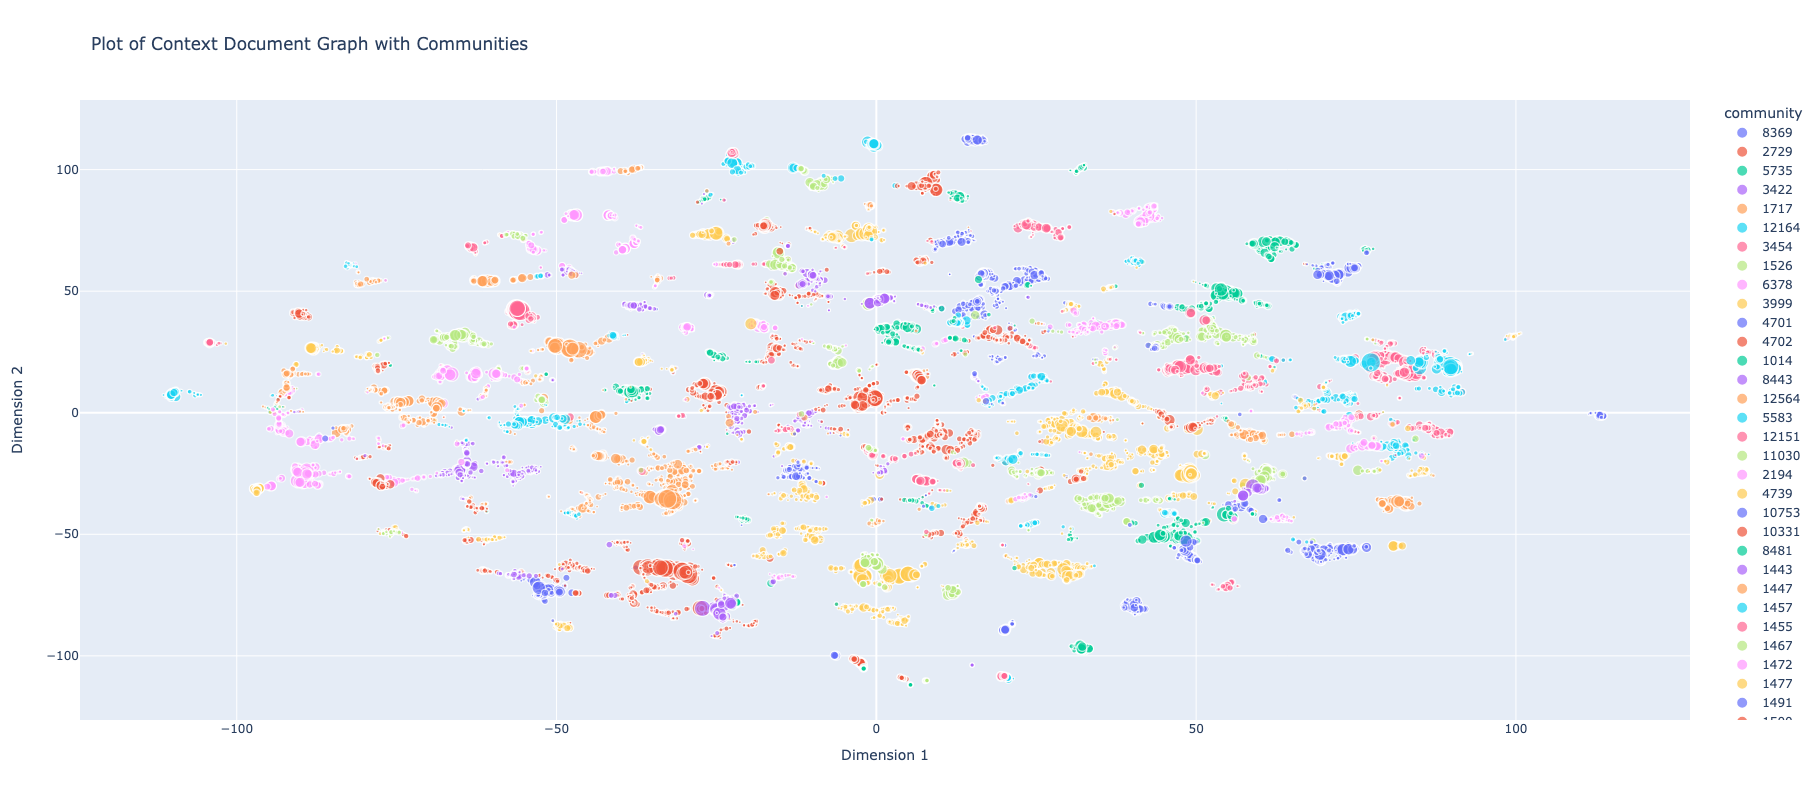

In [571]:
plot_2d_embeddings(embedding_df=doc_fastRP,
                   embeddings_col='fastRP',
                   labels_col='community',
                   size_col='pageRank',
                   plot_title='Plot of Context Document Graph with Communities')

While there is some overlap, which is to be expected, the plot above shows solid clustering and meaningful differentiation among the clusters. Based upon this, there are no apparent issues that should negatively impact performance in a meaningful way. 

# Analyze Combined Text and Graph Statistics Together

## Ask LLM for General Graph Analytic Advice
Now that we have text and GDS statistics, especially the communities, we can again ask ChatBison for its suggestions about how to proceed with our analysis. 

In [258]:
# start a new chat to ask about analyzing this dataframe 
textChat_obj = textChat_model.start_chat(
    context="You are an experienced, helpful graph data scientist who works at Neo4j."
)

In [259]:
prompt = f"""
I have a 14,500 row pandas DataFrame with the following features:
'url', string, which is the URL for the source document;
'text', string, which is a text portion of technical documentation or a technical blog post;
'text_len', int, which is the count of characters in the text;
'word_count', int', which is the count of words in the text;
'avg_word_len', float, which is the average word length in the text;
'community', which is the Label Propagation community to which the text belongs in a Neo4j graph, 
calculated based upon KNN similarity from an embedding of the text segment;
'pageRank', float, which is the PageRank score for the text node in a Neo4j graph, 
also calculated based upon KNN similarity from an embedding of the text segment;

I already performed preliminary data cleaning and preprocessing on the text. 
I have also already analyzed each feature individually. 

I want you to suggest ways I can analyze the data in aggregate, such as multiple features in relation to
one another. My goal is to understand the communities of text in the graph. The data in this graph will be
used to provide technical grounding context information to a chat agent powered by a large language
model.
"""

textChat_response = textChat_obj.send_message(prompt, **textChat_parameters)

print_markdown(textChat_response.text)

 Here are some suggestions for analyzing the data in aggregate:

* **Compare the distribution of text lengths, word counts, and average word lengths across the different communities.** This can give you a sense of how the communities differ in terms of their content.
* **Calculate the correlation between the different features.** This can help you identify which features are related to each other. For example, you might find that text length is correlated with word count, or that average word length is correlated with community.
* **Create a heat map of the correlations between the different features.** This can help you visualize the relationships between the features.
* **Use a dimensionality reduction technique, such as principal component analysis (PCA), to reduce the number of features.** This can make it easier to visualize the data and identify patterns.
* **Cluster the texts into groups based on their similarity.** This can help you identify groups of texts that are similar to each other in terms of their content.
* **Use a topic modeling technique, such as latent Dirichlet allocation (LDA), to identify the topics that are discussed in the texts.** This can help you understand the main themes of the texts.

These are just a few suggestions for analyzing the data in aggregate. There are many other ways to analyze the data, so feel free to explore and experiment until you find the methods that work best for your data.

## Aggregate DataFrame by Graph Community
Much of the analysis will revolve around the LPA Communities, so we will use Code Bison to get advice for aggregating the DataFrame by Community.

In [260]:
prompt = f"""
I have a 14,500 row pandas DataFrame with the following features:
'index', int, a unique identifier;
'text_len', int, which is the count of characters in some text;
'word_count', int', which is the count of words in some text;
'avg_word_len', float, which is the average word length in some text;
'community', int, which is the Label Propagation community to which the text belongs in a Neo4j graph, 
calculated based upon KNN similarity from an embedding of the text segment;
'pageRank', float, which is the PageRank score for the text node in a Neo4j graph, 
also calculated based upon KNN similarity from an embedding of the text segment;

Help me create a new DataFrame grouped by the community and containing the following features:
count of members based upon the 'index' value,
median tex_len,
median word_count,
median avg_word_len,
median pageRank
"""

codeGen_response = codeGen_model.predict(prefix = prompt, **codeGen_parameters)

print_markdown(codeGen_response.text)

```python
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('data.csv')

# Group the data by community and calculate the desired statistics
df_grouped = df.groupby('community').agg({
    'index': 'count',
    'text_len': 'median',
    'word_count': 'median',
    'avg_word_len': 'median',
    'pageRank': 'median'
})

# Print the resulting DataFrame
print(df_grouped)
```

In [263]:
# implement suggested code 
community_df = (
     context_df[['index', 'text_len', 'word_count', 'avg_word_len', 'community', 'pageRank']]
        .groupby('community')
        .agg({
            'index': 'count',
            'text_len': 'median',
            'word_count': 'median',
            'avg_word_len': 'median',
            'pageRank': 'median'
         })
)

# rename columns
community_df.columns = ['size', 'med_textLen', 'med_wordCount', 'med_avgWordLen', 'med_pageRank']

# sort by community size 
community_df.sort_values(by='size', ascending=False, inplace=True)

# confirm dataframe shape
community_df.shape

(160, 5)

### Show the Ten Largest Document Communities

In [279]:
community_df.head(10)

,size,med_textLen,med_wordCount,med_avgWordLen,med_pageRank
community,,,,,
3505,854,438.0,58.0,5.795,0.534879
1500,726,435.0,60.0,5.810,0.520925
13065,648,415.0,63.0,5.355,0.494910
11649,583,423.0,64.0,5.360,0.386139
12564,553,441.0,63.0,5.580,0.459630
8369,382,460.0,70.5,5.345,0.549432
655,324,451.0,68.0,5.300,0.708649
3921,302,505.0,57.0,7.760,0.661616
4575,279,451.0,68.0,5.500,0.705953


### Show the Ten Smallest Document Communities

In [271]:
community_df.tail()

,size,med_textLen,med_wordCount,med_avgWordLen,med_pageRank
community,,,,,
468,16,424.0,64.0,5.920,0.629133
1467,16,395.5,56.5,5.770,0.689264
5103,16,483.5,81.0,4.780,0.865827
10753,16,388.0,64.0,5.850,0.689019
968,14,471.0,71.5,5.615,0.752501
4249,13,496.0,60.0,5.620,0.328518
1652,13,474.0,65.0,5.490,0.442742
12870,11,271.0,33.0,7.160,0.462460
2039,11,485.0,75.0,5.390,0.704942


### Show Communities with the Highest Median PageRank
Sorting by median PageRank inadvertently identifies a potential outlier based upon median Average Word Length. This is one that we will want to investigate further.

In [272]:
community_df.sort_values(by='med_pageRank', ascending=False).head(10)

,size,med_textLen,med_wordCount,med_avgWordLen,med_pageRank
community,,,,,
14015,44,372.0,35.0,8.38,2.236358
755,30,507.0,78.0,5.50,1.893640
7117,51,512.0,1.0,512.00,1.811893
4506,25,479.0,46.0,8.16,1.677685
8299,22,422.5,68.0,5.22,1.603973
12142,27,465.0,61.0,6.71,1.498172
4035,43,407.0,70.0,4.83,1.495224
4701,51,373.0,50.0,6.88,1.468466
1455,22,422.0,56.0,6.77,1.466139


In [447]:
# re-sort by med_avgWordLen to see additional outliers
community_df.sort_values(by='med_avgWordLen', ascending=False).head(10)

,size,med_textLen,med_wordCount,med_avgWordLen,med_pageRank,context_freq
community,,,,,,
4213,17,512.0,1.0,512.00,1.305361,0.0
4207,17,512.0,1.0,512.00,0.787817,0.0
7117,51,512.0,1.0,512.00,1.811893,0.0
10745,19,511.0,1.0,511.00,1.129645,0.0
11823,23,511.0,1.0,511.00,1.147229,0.0
4212,18,511.0,1.0,511.00,1.259647,0.0
11148,17,332.0,1.0,332.00,1.228274,0.0
4206,35,204.0,1.0,204.00,1.030741,0.0
11180,17,172.0,1.0,172.00,0.573941,0.0


In [452]:
# view header of community 7117 to inspect
context_df[context_df['community'] == 7117].sort_values(by='pageRank', ascending=False).head()

,index,url,text,text_len,word_count,avg_word_len,community,pageRank
11076,11076,https://github.com/danb-neo4j/gds-guide/blob/main/graph-data-modeling.md,"{""payload"":{""allShortcutsEnabled"":false,""fileTree"":{"""":{""items"":[{""name"":""algorithms"",""path"":""algorithms"",""contentType"":""directory""},{""name"":""embeddings"",""path"":""embeddings"",""contentType"":""directory""},{""name"":""README.md"",""path"":""README.md"",""contentType"":""file""},{""name"":""gds-resources.md"",""path"":""gds-resources.md"",""contentType"":""file""},{""name"":""graph-data-modeling.md"",""path"":""graph-data-modeling.md"",""contentType"":""file""},{""name"":""graph-eda.md"",""path"":""graph-eda.md"",""contentType"":""file""},{""name"":""graphs-llms.",512,1,512.0,7117,2.415697
7509,7509,https://github.com/danb-neo4j/gds-guide/blob/main/graphs-llms.md,"{""payload"":{""allShortcutsEnabled"":false,""fileTree"":{"""":{""items"":[{""name"":""algorithms"",""path"":""algorithms"",""contentType"":""directory""},{""name"":""embeddings"",""path"":""embeddings"",""contentType"":""directory""},{""name"":""README.md"",""path"":""README.md"",""contentType"":""file""},{""name"":""gds-resources.md"",""path"":""gds-resources.md"",""contentType"":""file""},{""name"":""graph-data-modeling.md"",""path"":""graph-data-modeling.md"",""contentType"":""file""},{""name"":""graph-eda.md"",""path"":""graph-eda.md"",""contentType"":""file""},{""name"":""graphs-llms.",512,1,512.0,7117,2.413580
11171,11171,https://github.com/danb-neo4j/gds-guide/blob/main/gds-resources.md,"{""payload"":{""allShortcutsEnabled"":false,""fileTree"":{"""":{""items"":[{""name"":""algorithms"",""path"":""algorithms"",""contentType"":""directory""},{""name"":""embeddings"",""path"":""embeddings"",""contentType"":""directory""},{""name"":""README.md"",""path"":""README.md"",""contentType"":""file""},{""name"":""gds-resources.md"",""path"":""gds-resources.md"",""contentType"":""file""},{""name"":""graph-data-modeling.md"",""path"":""graph-data-modeling.md"",""contentType"":""file""},{""name"":""graph-eda.md"",""path"":""graph-eda.md"",""contentType"":""file""},{""name"":""graphs-llms.",512,1,512.0,7117,2.288317
3907,3906,https://github.com/danb-neo4j/gds-guide/blob/main/graph-eda.md,"{""payload"":{""allShortcutsEnabled"":false,""fileTree"":{"""":{""items"":[{""name"":""algorithms"",""path"":""algorithms"",""contentType"":""directory""},{""name"":""embeddings"",""path"":""embeddings"",""contentType"":""directory""},{""name"":""README.md"",""path"":""README.md"",""contentType"":""file""},{""name"":""gds-resources.md"",""path"":""gds-resources.md"",""contentType"":""file""},{""name"":""graph-data-modeling.md"",""path"":""graph-data-modeling.md"",""contentType"":""file""},{""name"":""graph-eda.md"",""path"":""graph-eda.md"",""contentType"":""file""},{""name"":""graphs-llms.",512,1,512.0,7117,2.234349
11982,11982,https://github.com/danb-neo4j/gds-guide/blob/main/README.md,"{""payload"":{""allShortcutsEnabled"":false,""fileTree"":{"""":{""items"":[{""name"":""algorithms"",""path"":""algorithms"",""contentType"":""directory""},{""name"":""embeddings"",""path"":""embeddings"",""contentType"":""directory""},{""name"":""README.md"",""path"":""README.md"",""contentType"":""file""},{""name"":""gds-resources.md"",""path"":""gds-resources.md"",""contentType"":""file""},{""name"":""graph-data-modeling.md"",""path"":""graph-data-modeling.md"",""contentType"":""file""},{""name"":""graph-eda.md"",""path"":""graph-eda.md"",""contentType"":""file""},{""name"":""graphs-llms.",512,1,512.0,7117,2.215662


Because we have these outliers grouped by community, it is likely that we can delete the entire community from our graph to remove the messy text and not negatively impact the quality of the database. In fact, deleting these types of outliers will likely iimprove database performance because the dirty data will not be passed to the LLM for grounding. 

## Analyze Context Similarity
Given the relatively high similarity relationships among the context documents, we want to identify identical or near-identical context for consolidation. This will improve the overall efficency of our grounding database. 

We intentionally scraped many of the documents from public Neo4j website so that we would have URLs to use as references when Agent Neo provided responses. However, one downside of this approach is that many documents may contain the same, or nearly the same, portions content whether it is technical content or website boilerplate. By calculating the KNN Similarity relationships and clustering document chunks, we can attempt to identify those documents that can be consolidated without negatively impacting the model's performance. 

### Identify Document Nodes with One or More 99% Similarity Relationships
First we will query the database to get a count of Document nodes that have at least one SIMILARITY relationship of 0.99 or higher.

In [426]:
gds.run_cypher('''
MATCH (d1:Document)-[r:SIMILARITY]-(d:Document)
WHERE r.score >= 0.99
RETURN COUNT(DISTINCT d1)
''')

,COUNT(DISTINCT d1)
0,2919


### Count of 99% SIMILAR Relationships

In [420]:
gds.run_cypher('''
MATCH (d1:Document)-[r:SIMILARITY]->(d2:Document)
WHERE r.score >= 0.99
RETURN COUNT(r) AS count
''')

,count
0,9010


### Generate DataFrame of Highly Similar Text Chunks

In [620]:
# query for node and text details from the 99% similarity relationships
docs_99pct_similar = gds.run_cypher('''
MATCH (d1:Document)-[r:SIMILARITY]-(d:Document)
WHERE r.score >= 0.99
RETURN DISTINCT 
d1.index AS index, d1.url AS url, d1.text AS text, d1.community AS community
''')

docs_99pct_similar.shape

(2919, 4)

In [621]:
# sort dataframe and visualize head
docs_99pct_similar.sort_values(by='community', ascending=True, inplace=True)

docs_99pct_similar.head(5)

,index,url,text,community
40,253,https://neo4j.com/docs/operations-manual/current/kubernetes/quickstart-standalone/verify-installation/,Check that the services look OK: kubectl get services,249
38,243,https://neo4j.com/docs/operations-manual/current/kubernetes/quickstart-standalone/verify-installation/,Check that the services look OK: kubectl get services,249
41,254,https://neo4j.com/docs/operations-manual/current/kubernetes/quickstart-standalone/verify-installation/,"NAME TYPE CLUSTER-IP EXTERNAL-IP PORT(S) AGE kubernetes ClusterIP 10.96.0.1 <none> 443/TCP 3d1h my-neo4j-release ClusterIP 10.103.103.142 <none> 7687/TCP,7474/TCP,7473/TCP 2d8h my-neo4j-release-admin ClusterIP 10.99.11.122 <none> 6362/TCP,7687/TCP,7474/TCP,7473/TCP 2d8h",255
39,244,https://neo4j.com/docs/operations-manual/current/kubernetes/quickstart-standalone/verify-installation/,"NAME TYPE CLUSTER-IP EXTERNAL-IP PORT(S) AGE service/my-neo4j-release-lb-neo4j LoadBalancer 10.36.5.34 34.105.179.172 7474:30288/TCP,7473:30786/TCP,7687:30584/TCP 14m service/kubernetes ClusterIP 10.36.0.1 <none> 443/TCP 22h",255
2063,9861,https://neo4j.com/docs/python-manual/current/connect-advanced/,"transaction A transaction is a unit of work that is either committed in its entirety or rolled back on failure. An example is a bank transfer: it involves multiple steps, but they must all succeed or be reverted, to avoid money being subtracted from one account but not added to the other. backpressure Backpressure is a force opposing the flow of data. It ensures that the client is not being overwhelmed by data faster than it can handle. transaction function",261


### Document Communities with Highest Similarity Scores
A more efficient way to approach this will be to focus on Document Communities with the highest median similarity scores. This will provide natural groupings that we likely can consolidate into a single Document node linked to all of the applicable source URLs. 

In [416]:
community_similarity_df = gds.run_cypher('''
MATCH (d:Document)
WITH DISTINCT d.community AS community
MATCH (d1:Document)-[r:SIMILARITY]->(d2:Document) 
    WHERE 
        d1.community = community AND 
        d2.community = community
WITH community, avg(r.score) AS average_similarity, count(DISTINCT d1) AS node_count, count(r) AS relationship_count
RETURN community, average_similarity, node_count, relationship_count
''')

community_similarity_df.sort_values(by='average_similarity', ascending=False, inplace=True)
community_similarity_df.shape

(160, 4)

In [418]:
community_similarity_df.head()

,community,average_similarity,node_count,relationship_count
106,4213,0.991812,17,272
11,4702,0.986700,49,1207
111,11148,0.986366,17,272
138,6979,0.985077,71,1553
107,11180,0.982547,17,272


### View Highly-Similar Documentation
We can explore a community near the top of the similarity to see if our theory holds. 

In [445]:
context_df[context_df['community'] == 4702][['url', 'text', 'community']].head()

,url,text,community
29,https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/graph-sage/,"Heterogeneous relationships Heterogeneous relationships fully supported. The algorithm has the ability to distinguish between relationships of different types. Heterogeneous relationships Heterogeneous relationships allowed. The algorithm treats all selected relationships similarly regardless of their type. Weighted relationships Weighted trait. The algorithm supports a relationship property to be used as weight, specified via the relationshipWeightProperty configuration parameter.",4702
329,https://neo4j.com/docs/graph-data-science/current/algorithms/harmonic-centrality/,"Heterogeneous relationships Heterogeneous relationships fully supported. The algorithm has the ability to distinguish between relationships of different types. Heterogeneous relationships Heterogeneous relationships allowed. The algorithm treats all selected relationships similarly regardless of their type. Weighted relationships Weighted trait. The algorithm supports a relationship property to be used as weight, specified via the relationshipWeightProperty configuration parameter.",4702
416,https://neo4j.com/docs/graph-data-science/current/algorithms/bellman-ford-single-source/,"Heterogeneous relationships Heterogeneous relationships fully supported. The algorithm has the ability to distinguish between relationships of different types. Heterogeneous relationships Heterogeneous relationships allowed. The algorithm treats all selected relationships similarly regardless of their type. Weighted relationships Weighted trait. The algorithm supports a relationship property to be used as weight, specified via the relationshipWeightProperty configuration parameter.",4702
456,https://neo4j.com/docs/graph-data-science/current/algorithms/modularity-optimization/,"Heterogeneous relationships Heterogeneous relationships fully supported. The algorithm has the ability to distinguish between relationships of different types. Heterogeneous relationships Heterogeneous relationships allowed. The algorithm treats all selected relationships similarly regardless of their type. Weighted relationships Weighted trait. The algorithm supports a relationship property to be used as weight, specified via the relationshipWeightProperty configuration parameter.",4702
1013,https://neo4j.com/docs/graph-data-science/current/algorithms/closeness-centrality/,"Heterogeneous relationships Heterogeneous relationships fully supported. The algorithm has the ability to distinguish between relationships of different types. Heterogeneous relationships Heterogeneous relationships allowed. The algorithm treats all selected relationships similarly regardless of their type. Weighted relationships Weighted trait. The algorithm supports a relationship property to be used as weight, specified via the relationshipWeightProperty configuration parameter.",4702


To consoldiate these relationships we can use a function like `apoc.nodes.collapse()` to collapse an entire community of nodes into a single node while rewiring all of the HAS_SOURCE relationships to that single, consolidated node. This can greately improve the efficency of our grounding database.

# Analyzing LLM Conversations 
In this section we will analyze the user conversations with Agent Neo. Logging conversations in a Neo4j Knowledge Graph provides a unique capability to visualize and analyze the conversations along side the grounding context provided to the LLM to generate responses. 

## Refresh Node and Relationship Counts
To this point we have only analyzed Document and URL nodes, with their corresponding HAS_SOURCE and SIMILARITY relationships. Now we will expand that analysis to other node and relationship types.

In [373]:
# re-visit node types in the graph
nodeLabels = gds.run_cypher("""
                            CALL apoc.meta.stats()
                            YIELD labels
                            UNWIND keys(labels) AS nodeLabel
                            RETURN nodeLabel, labels[nodeLabel] AS nodeCount
                              """)
print('Node labels with counts:')
nodeLabels 

Node labels with counts:


,nodeLabel,nodeCount
0,Conversation,51
1,Document,14476
2,Message,303
3,URL,1157
4,Session,39


In [374]:
# re-visit label types in the graph 
relType_labels = gds.run_cypher("""
                                CALL apoc.meta.stats()
                                YIELD relTypesCount
                                UNWIND keys(relTypesCount) AS relationshipType
                                RETURN relationshipType, relTypesCount[relationshipType] AS relationshipCount
                                ORDER BY relationshipCount DESC
                                """)
relType_labels

,relationshipType,relationshipCount
0,SIMILARITY,361900
1,HAS_SOURCE,14476
2,HAS_CONTEXT,1136
3,NEXT,252
4,HAS_CONVERSATION,51
5,FIRST,51


## Ask LLM for Advice Analyzing Conversation Graphs
Now that we are expanding our analysis to graphed conversations, we can start a new chat with ChatBison to get its perspective on analyzing the LLM interactions.

In [383]:
# start a new chat to ask about analyzing this dataframe 
textChat_obj = textChat_model.start_chat(
    context="You are an experienced, helpful graph data scientist who works at Neo4j."
)

In [384]:
# provide details about the conversation graph in the prompt 
prompt = f"""
I want you to help me analyze data from an LLM application I am logging in a Neo4j graph database. 
Users of this application ask questions to the LLM about the Neo4j Graph Data Science library,
and the LLM answers those questions with help from context documentation, also contained in the Neo4j database. 

I am logging user sessions and interactions with the LLM in the following graph data model:
(s:Session)-[HAS_CONVERSATION]->(c:Conversation)-[FIRST]->(:Message)-[NEXT]->(:Message)

A session can have multiple conversations, and a conversation can have many messages. 
Each message can be connected to up to 10 context Documents as follows:
(m:Message)-[HAS_CONTEXT]->(d:Document)

Messages can, and often do, share context Documents.

Let's take this step-by-step. First, I want you to help me brainstorm analytical insights I 
could attempt to derive from the data in this graph, with the goal of understanding the logged 
data of user interactions with the LLM as well as how the LLM is using context documents
to answer the user questions. 
"""

textChat_response = textChat_obj.send_message(prompt, **textChat_parameters)

print_markdown(textChat_response.text)

 Here are some analytical insights you could attempt to derive from the data in this graph:

* **How many users are using the LLM application?** This can be determined by counting the number of distinct users in the graph.


* **What is the average length of a conversation?** This can be determined by calculating the average number of messages in a conversation.


* **What is the most common type of question asked by users?** This can be determined by analyzing the text of the messages and identifying the most common topics.


* **What is the most common context document used by the LLM to answer questions?** This can be determined by analyzing the relationships between messages and documents.


* **How often does the LLM use context documents to answer questions?** This can be determined by calculating the percentage of messages that have a relationship to a context document.


* **How well is the LLM performing in answering questions?** This can be determined by analyzing the accuracy and relevance of the LLM's answers.


* **How satisfied are users with the LLM application?** This can be determined by surveying users or analyzing their feedback.


* **What are the most common pain points for users when using the LLM application?** This can be determined by analyzing user feedback and identifying the most common issues.


* **What are the most common suggestions for improving the LLM application?** This can be determined by analyzing user feedback and identifying the most common suggestions.

## Session and Conversation Statistics
As part of analyzing the conversations we will create new properties:
* Conversations per User Session
* Conversation Lengths

### Conversations per User Session 

In [471]:
# set new property on Session nodes
gds.run_cypher('''
MATCH (s:Session)-[r:HAS_CONVERSATION]->(c:Conversation)
WITH s, count(c) AS conversation_count
SET s.conversation_count = conversation_count
''')

""


In [472]:
# generate dataframe with sessions and conversation count
session_count = gds.run_cypher('''
MATCH (s:Session) 
RETURN 
    s.id AS id,
    s.conversation_count as conversation_count
''')

session_count.shape

(59, 2)

In [477]:
# generate a distribution 
session_dist = session_count['conversation_count'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]).round()
session_dist

count    59.0
mean      1.0
std       1.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
90%       2.0
95%       2.0
99%       4.0
99.9%     5.0
max       5.0
Name: conversation_count, dtype: float64

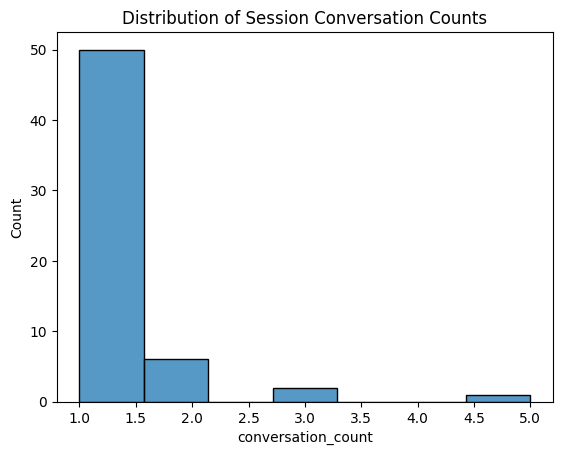

In [475]:
# plot the distribution 
sns.histplot(data=session_count, x='conversation_count')
plt.title('Distribution of Session Conversation Counts')
plt.show()

In [478]:
# ask ChatBison for its interpretation of the distribution 
prompt = f"""
Continuing the conversation, help me interpret the results of the Session Conversation 
Distribution, which is the count of LLM application user conversations per session.

The distribution is in the following object: {session_dist}

As the application technical project manager, how should I interpret these results?
"""

textChat_response = textChat_obj.send_message(prompt, **textChat_parameters)

print_markdown(textChat_response.text)

 The Session Conversation Distribution shows the distribution of the number of conversations per session. The mean and median are both 1.0, which indicates that most sessions have only one conversation. However, the maximum is 5.0, which indicates that there are some sessions with a large number of conversations. The 90th percentile is 2.0, which indicates that 90% of sessions have 2 or fewer conversations.

This distribution could be interpreted in a few ways. One possible interpretation is that users are generally satisfied with the LLM application and do not need to have multiple conversations to get their questions answered. Another possible interpretation is that users are not able to find the information they need in the LLM application and need to have multiple conversations to get their questions answered.

As the application technical project manager, you could use this information to help improve the LLM application. For example, you could add more context documents to the application so that users can find the information they need more easily. You could also add features to the application that allow users to have more conversations with the LLM.

### Conversation Length
This statistic will count the number of messages per each conversation. Note that each question and answer is one message, so dividing the total by two will approximate the number of questions the user asks. 

In [479]:
# create new property on Conversation nodes
gds.run_cypher('''
MATCH (c:Conversation)-[r:FIRST]->(m:Message)
WITH c, m
MATCH path = (m)-[:NEXT*]->(:Message)
WITH c, length(path) + 1 AS conversation_length
SET c.conversation_length = conversation_length
''') 

""


In [482]:
# generate dataframe for each conversation length 
conversation_lengths = gds.run_cypher('''
MATCH (c:Conversation)
RETURN 
    c.id AS id,
    c.conversation_length AS conversation_length
''')

conversation_lengths.shape

(73, 2)

In [483]:
# generate distribution for conversation lengths 
convo_len_dist = conversation_lengths['conversation_length'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]).round()
convo_len_dist

count    72.0
mean      6.0
std       4.0
min       2.0
25%       2.0
50%       4.0
75%       8.0
90%      10.0
95%      15.0
99%      20.0
99.9%    24.0
max      24.0
Name: conversation_length, dtype: float64

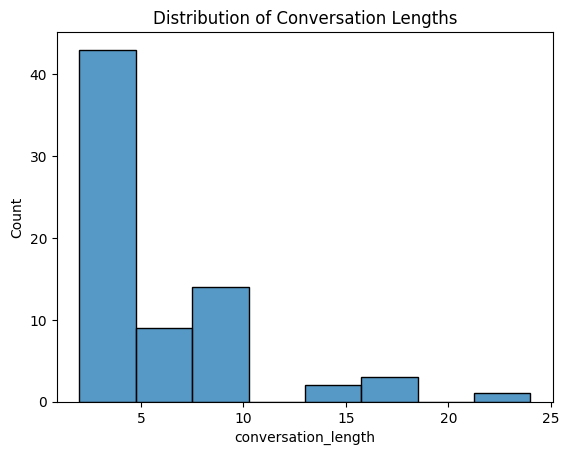

In [485]:
# plot conversation lengths 
sns.histplot(data=conversation_lengths, x='conversation_length')
plt.title('Distribution of Conversation Lengths')
plt.show()

In [486]:
# ask ChatBison for its interpretation of the conversation length distribution 
prompt = f"""
Continuing the conversation, help me interpret the results of the Conversation Length
Distribution, which is the length of each individual conversation a user has
with the LLM.

The conversation length distribution is in the following object: {convo_len_dist}

As the application technical project manager, how should I interpret these results?
"""

textChat_response = textChat_obj.send_message(prompt, **textChat_parameters)

print_markdown(textChat_response.text)

 The Conversation Length Distribution shows the distribution of the number of messages in a conversation. The mean is 6.0, which indicates that the average conversation is 6 messages long. However, the median is 4.0, which indicates that most conversations are shorter than 6 messages. The maximum is 24.0, which indicates that there are some very long conversations. The 90th percentile is 10.0, which indicates that 90% of conversations are 10 messages or shorter.

This distribution could be interpreted in a few ways. One possible interpretation is that users are generally able to get their questions answered in a small number of messages. Another possible interpretation is that users are not able to find the information they need in the LLM application and need to have longer conversations to get their questions answered.

As the application technical project manager, you could use this information to help improve the LLM application. For example, you could add more context documents to the application so that users can find the information they need more easily. You could also add features to the application that allow users to have more conversations with the LLM.

### Evaluate Conversation Quality
The Agent Neo user interface provides users with the ability to rate each conversation as "Good" or "Bad." To capture this as a statistic we will create new properties on the Conversation nodes to count "Good" and "Bad" ratings provided throughout the entire conversation. Note that this feature was added after testing and users have been slow or inconsistent in rating conversations.

In [521]:
# create Good and Bad features on Conversation nodes
gds.run_cypher('''
MATCH (c:Conversation)-[:FIRST|NEXT*]->(m:Message)
WITH c, m.rating as rating
WITH c, 
     count(case when rating = 'Good' then 1 else null end) as GoodMessagesCount,
     count(case when rating = 'Bad' then 1 else null end) as BadMessagesCount
SET 
    c.GoodMessagesCount = GoodMessagesCount, 
    c.BadMessagesCount = BadMessagesCount
''')

""


In [526]:
# generate new dataframe with conversation lengths as well as Good and Bad ratings
conversation_ratings = gds.run_cypher('''
MATCH (c:Conversation)
RETURN
    c.id AS id,
    c.conversation_length AS conversation_length,
    c.GoodMessagesCount AS GoodMessagesCount, 
    c.BadMessagesCount AS BadMessagesCount
''')

conversation_ratings.shape

(74, 4)

In [536]:
# add additional summarizaton features 
conversation_ratings['TotalRatings'] = conversation_ratings['GoodMessagesCount'] + conversation_ratings['BadMessagesCount']
conversation_ratings['PositiveRatio'] = round(conversation_ratings['GoodMessagesCount']/conversation_ratings['TotalRatings'], 2)

In [533]:
# generate summary stats of conversation results 
total_messages = conversation_ratings['GoodMessagesCount'].sum() + conversation_ratings['BadMessagesCount'].sum()

print('Total Message Ratings:', total_messages)
print('Good Message Ratings:', conversation_ratings['GoodMessagesCount'].sum())
print('Good Message Ratio:', round(conversation_ratings['GoodMessagesCount'].sum()/total_messages, 2))
print('Bad Message Ratings:', conversation_ratings['BadMessagesCount'].sum())
print('Bad Message Ratio:', round(conversation_ratings['BadMessagesCount'].sum()/total_messages, 2))


Total Message Ratings: 113
Good Message Ratings: 87
Good Message Ratio: 0.77
Bad Message Ratings: 26
Bad Message Ratio: 0.23


We attempted to visualize the results in a scatterplot, but at this point it did not provide meaningful results.

## Context Document Frequency
Another aspect where graph can be highly useful is to analyze how frequently documents are used for grounding LLM responses.

### Generate Context Frequency Feature
We will use the GDS Degree Centrality algorithm to generate relationship counts for documents connected to LLM messages. Note that we use the 'REVERSE' orientation because Degree Cenrality defaults to outgoing relationships.

In [457]:
# # if necessary, view existing graph projections
# gds.graph.list()

In [489]:
# # if necessary, drop a projection 
# _ = g.drop()

In [490]:
# create graph projection, flipping relationships 
g, _ = gds.graph.project(graph_name='conversation_context',
                         node_spec=['Document', 'Message'],
                         relationship_spec={'HAS_CONTEXT': {'orientation': 'REVERSE'}})

In [491]:
# write relationships to the graph 
_ = gds.degree.write(G=g, 
                     nodeLabels = ['Document', 'Message'],
                     relationshipTypes = ['HAS_CONTEXT'],
                     writeProperty='contextCount')

In [493]:
# # if necessary, delete counts written to Messages
# _ = gds.run_cypher('''
# MATCH (m:Message)
# REMOVE m.contextCount
# ''')

### View Most Frequent Context
Now that we created the new statistic we will investigate the most frequently used documents. 

In [494]:
# generate a new dataframe with contextCount statistics 
context_frequency_df = gds.run_cypher('''
MATCH (d:Document)
RETURN
    d.index AS index,
    d.contextCount AS context_count,
    d.text AS text,
    d.community AS community
ORDER BY context_count DESC
''')
context_frequency_df.shape

(14476, 4)

In [503]:
# view top five most frequently used documents 
context_frequency_df.head()

,index,context_count,text,community
0,3968,10.0,"GDS Degree Centrality algorithm is useful for creating statistics that can support calculating ratios and identifying outliers. The same could also be performed using Cypher (and, if a large graph, apoc.periodic.iterate()). However, one of the benefits of using GDS and Graph Projections is that we can create a single projection and run multiple algorithms on it.</p>\n<br>\nFor example, if we were analyzing a financial transaction network we may want to identify customers who had the most transactions. We",2729
1,3172,9.0,"Neo4j Data Connectors Apache Kafka, Apache Spark, and BI tools Cypher Query Language Powerful, intuitive, and graph-optimized Solutions Use Cases Fraud detection, knowledge graphs and more Generative AI Back your LLMs with a knowledge graph for better business AI Learn More",13065
2,7530,9.0,"want you to act as an experienced graph data scientist who works at Neo4j. A customer asks you how large language models (LLMs) like ChatGPT can assist with graph data science, specifically using Neo4j Graph Data Science algorithms. How would you advise this customer to explore integrating LLMs into their graph data science workflows? What would likely be the easiest or most impactful ways in which an LLM can make them more productive and effective?</em></p>\n<h2 tabindex=\""-1\"" dir=\""auto\""><a",11649
3,10161,9.0,"Perhaps you are a data scientist, or you aspire to become one. Graph analytics and data science offer a wide variety of algorithms that can enhance your analytical toolbox and help you find meaningful insights into highly-connected datasets. In this section, I will show how easily you can integrate graph algorithms into your analytical workflows. Neo4j offers a Python client for Neo4j Graph Data Science library that seamlessly allows you to execute graph algorithms using only Python code.",13065
4,7851,7.0,"Neo4j Data Connectors Apache Kafka, Apache Spark, and BI tools Cypher Query Language Powerful, intuitive, and graph-optimized Solutions Use Cases Fraud detection, knowledge graphs and more Generative AI Back your LLMs with a knowledge graph for better business AI Learn More",13065


In [509]:
print('count of grounding documents used at least once', context_frequency_df[context_frequency_df['context_count'] > 0].shape[0])
print('count of unused grounding documents', context_frequency_df[context_frequency_df['context_count'] == 0].shape[0])
print('percentage of grounding documents used', round(context_frequency_df[context_frequency_df['context_count'] > 0].shape[0] / context_frequency_df.shape[0], 2))

count of grounding documents used at least once 1056
count of unused grounding documents 13420
percentage of grounding documents used 0.07


In [496]:
# generate a new distribution 
print('distribution of context frequency with minimum of one')
context_frequency_df[context_frequency_df['context_count'] > 0]['context_count'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]).round()


distribution of context frequency with minimum of one


count    1056.0
mean        1.0
std         1.0
min         1.0
25%         1.0
50%         1.0
75%         2.0
90%         3.0
95%         4.0
99%         6.0
99.9%       9.0
max        10.0
Name: context_count, dtype: float64

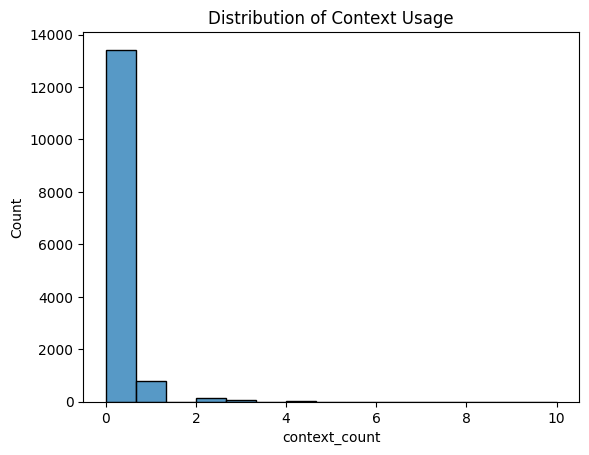

In [512]:
# visualize the distribution 
sns.histplot(data=context_frequency_df, x='context_count')
plt.title('Distribution of Context Usage')
plt.show()

### Combine Context Usage with Communities
In addition to individual documents, we also want to see the Communities that most frequently provide context documents for response grounding.

In [497]:
# Create a new dataframe of resposne totals aggregated by community 
context_comm_freq = context_frequency_df.groupby('community').agg({'context_count': 'sum'})
context_comm_freq.columns = ['context_freq']
context_comm_freq.sort_values(by='context_freq', ascending=False, inplace=True)
context_comm_freq.shape

(160, 1)

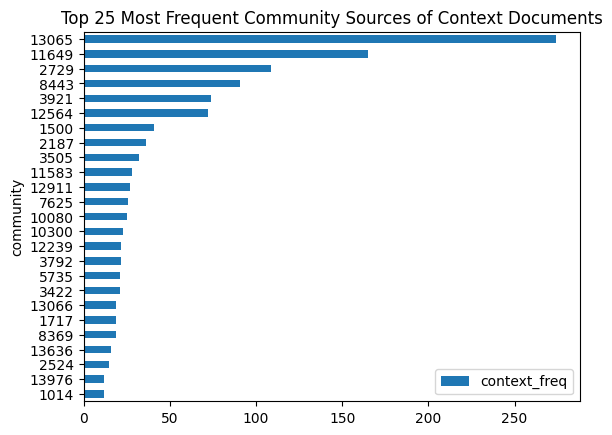

In [517]:
# visualize top 25 communities 
context_comm_freq.head(25).sort_values(by='context_freq', ascending=True).plot(kind='barh')
plt.title('Top 25 Most Frequent Community Sources of Context Documents')
plt.show()

In [500]:
# drop unneeded column
community_df.drop('context_freq', axis=1, inplace=True)

In [501]:
## Merge community use count 
community_df = pd.merge(community_df, context_comm_freq, on="community")
community_df.sort_values(by='context_freq', ascending=False, inplace=True)
community_df.shape

(160, 6)

In [502]:
# view most frequent communities 
community_df.head(10)

,size,med_textLen,med_wordCount,med_avgWordLen,med_pageRank,context_freq
community,,,,,,
13065,648,415.0,63.0,5.355,0.494910,274.0
11649,583,423.0,64.0,5.360,0.386139,165.0
2729,218,432.0,46.0,6.610,0.552022,109.0
8443,244,445.0,64.0,5.605,0.425977,91.0
3921,302,505.0,57.0,7.760,0.661616,74.0
12564,553,441.0,63.0,5.580,0.459630,72.0
1500,726,435.0,60.0,5.810,0.520925,41.0
2187,268,456.0,64.0,5.495,0.436266,36.0
3505,854,438.0,58.0,5.795,0.534879,32.0


In [519]:
# view samples from a community sorted by PageRank
context_df[context_df['community'] == 11649].sort_values(by='pageRank', ascending=False).head(10)

,index,url,text,text_len,word_count,avg_word_len,community,pageRank
12276,12276,https://towardsdatascience.com/integrating-neo4j-into-the-langchain-ecosystem-df0e988344d2,"11 min read·Jul 18 25 - 25 Tomaz Bratanic in Neo4j Developer Blog Knowledge Graphs & LLMs: Fine-Tuning Vs. Retrieval-Augmented GenerationWhat are the limitations of LLMs, and how to overcome them 12 min read·Jun 6 7 - Dominik Polzer in Towards Data Science All You Need to Know to Build Your First LLM AppA step-by-step tutorial to document loaders, embeddings, vector stores and prompt templates 26 min read·Jun 22 38 - 38 Leonie Monigatti in Towards Data Science",464,78,4.96,11649,8.510621
8297,8297,https://medium.com/neo4j/knowledge-graphs-llms-fine-tuning-vs-retrieval-augmented-generation-30e875d63a35,Tomaz Bratanic in Neo4j Developer Blog Knowledge Graphs & LLMs: Real-Time Graph AnalyticsUnderstanding data points through the context of their relationships 9 min read·Jul 12 - Tomaz Bratanic in Neo4j Developer Blog Knowledge Graphs & LLMs: Multi-Hop Question AnsweringRetrieve information that spans across multiple documents 10 min read·Jun 15 4 - Oskar Hane in Neo4j Developer Blog Harnessing Large Language Models with Neo4jEpisode 1 — Exploring Real-World Use Cases 5 min read·May 26 1,491,74,5.65,11649,8.340022
6277,6276,https://medium.com/neo4j/using-neo4j-graph-data-science-in-python-to-improve-machine-learning-models-c55a4e15f530,12 min read·Jun 6 7 - Tomaz Bratanic in Neo4j Developer Blog Context-Aware Knowledge Graph Chatbot With GPT-4 and Neo4jLearn how to implement a chatbot that bases its answers on the information retrieved from a graph database. 16 min read·Apr 11 7 - Tomaz Bratanic in Neo4j Developer Blog Knowledge Graphs & LLMs: Multi-Hop Question AnsweringRetrieve information that spans across multiple documents 10 min read·Jun 15 4 - Leonie Monigatti in Towards Data Science,463,74,5.27,11649,7.656310
8706,8706,https://medium.com/neo4j/how-to-get-started-with-the-neo4j-graph-data-science-python-client-56209d9b0d0d,"- Tomaz Bratanic in Neo4j Developer Blog Knowledge Graphs & LLMs: Fine-Tuning Vs. Retrieval-Augmented GenerationWhat are the limitations of LLMs, and how to overcome them 12 min read·Jun 6 7 - Tomaz Bratanic in Neo4j Developer Blog Context-Aware Knowledge Graph Chatbot With GPT-4 and Neo4jLearn how to implement a chatbot that bases its answers on the information retrieved from a graph database. 16 min read·Apr 11 7 - Tomaz Bratanic in Neo4j Developer Blog",459,74,5.22,11649,7.440108
12683,12683,https://medium.com/neo4j/enhancing-word-embedding-with-graph-neural-networks-c26d8e54fe4a,"Tomaz Bratanic in Neo4j Developer Blog Knowledge Graphs & LLMs: Real-Time Graph AnalyticsUnderstanding data points through the context of their relationships 9 min read·Jul 12 - Tomaz Bratanic in Neo4j Developer Blog Knowledge Graphs & LLMs: Fine-Tuning Vs. Retrieval-Augmented GenerationWhat are the limitations of LLMs, and how to overcome them 12 min read·Jun 6 7 - Tomaz Bratanic in Neo4j Developer Blog",407,62,5.58,11649,7.361508
10652,10652,https://towardsdatascience.com/langchain-has-added-cypher-search-cb9d821120d5,"Tomaz Bratanic in Neo4j Developer Blog Knowledge Graphs & LLMs: Real-Time Graph AnalyticsUnderstanding data points through the context of their relationships 9 min read·Jul 12 - Dominik Polzer in Towards Data Science All You Need to Know to Build Your First LLM AppA step-by-step tutorial to document loaders, embeddings, vector stores and prompt templates 26 min read·Jun 22 38 - 38 Kenneth Leung in Towards Data Science",421,67,5.30,11649,7.223435
11650,11650,https://medium.com/neo4j/context-aware-knowledge-graph-chatbot-with-gpt-4-and-neo4j-d3a99e8ae21e,"- Tomaz Bratanic in Neo4j Developer Blog Knowledge Graphs & LLMs: Fine-Tuning Vs. Retrieval-Augmented GenerationWhat are the limitations of LLMs, and how to overcome them 12 min read·Jun 6 7 - Oskar Hane in Neo4j Developer Blog Harnessing Large Language Models with Neo4jEpisode 1 — Explorin

## Evaluate LLM Responses Based Upon Context Documents 
We can use GDS algorithms to analyze and visualize LLM responses based upon the Context Documents provided to the LLM for generating the response. This workflow will follow similar steps that we used for evaluating context documents and generating embeddings.

### Create Secondary Label
First we will create a secondary node label on Message nodes that are specific to LLM responses. This will make it easier to create a graph projection using the Native Projection procedure.

In [540]:
# add secondary label to Messages
gds.run_cypher('''
MATCH (m:Message)
WHERE m.role = "assistant"
SET m:Assistant
''') 

""


### Create Bi-Partite Graph Projection
Next we will create a bi-partitie graph projection of (a:Assistant)-[:HAS_CONTEXT]->(d:Document).

In [542]:
# specify projection config
node_projection = ['Assistant', 'Document']
relationship_projection = {'HAS_CONTEXT': {'orientation': 'NATURAL'}}

# generate graph projection 
g, _ = gds.graph.project(
          graph_name = 'doc-response', 
          node_spec = node_projection, 
          relationship_spec = relationship_projection)

### Run Node Similarity
We will run Node Similarity in MUTATE mode so that we do not write the relationships back to the graph. While we wrote the Document similarity relationships back to the graph earlier in this process so that we could visualize them, this time we will simply analyze them in memory. 

In [547]:
_ = gds.nodeSimilarity.mutate(G = g, 
                              mutateRelationshipType='RESPONSE_SIMILARITY', 
                              mutateProperty='similarityScore',
                              similarityCutoff=0.01, 
                              concurrency=4)

In [549]:
# view the similarity distribution 
pd.DataFrame(_)[0]['similarityDistribution']

{'min': 0.052631378173828125,
 'p5': 0.052631378173828125,
 'max': 1.0000073909759521,
 'p99': 0.571429967880249,
 'p1': 0.052631378173828125,
 'p10': 0.052631378173828125,
 'p90': 0.2500016689300537,
 'p50': 0.09090924263000488,
 'p25': 0.06666684150695801,
 'p75': 0.14285731315612793,
 'p95': 0.4285714626312256,
 'mean': 0.1317055822618051,
 'p100': 1.0000073909759521,
 'stdDev': 0.12511114426115452}

### Identify Communities via Label Propagation
As before, we will also run Label Propagation on the similarity graph to identify communities. We first run it in stats mode to understand the expected distribution, then we run it in write mode to save the communities as properties on the Assistant message nodes. 

In [573]:
# run LAP in stats 
_ = gds.labelPropagation.stats(G = g, 
                               nodeLabels = ['Assistant'],
                               relationshipTypes = ['RESPONSE_SIMILARITY'],
                               relationshipWeightProperty = 'similarityScore')

In [576]:
# inspect community count and community distribution 
pd.DataFrame(_)[0][['communityCount', 'communityDistribution']]

communityCount                                                                                                                           57
communityDistribution    {'min': 1, 'max': 25, 'p90': 11, 'p999': 25, 'p99': 25, 'p50': 2, 'p75': 4, 'p95': 14, 'mean': 3.5964912280701755}
Name: 0, dtype: object

In [553]:
# write to Assistant nodes
_ = gds.labelPropagation.write(G = g, 
                               nodeLabels = ['Assistant'],
                               relationshipTypes = ['RESPONSE_SIMILARITY'],
                               relationshipWeightProperty = 'similarityScore',
                               writeProperty = 'responseCommunity')

### Run PageRank
Once again, PageRank will give us a proxy for the importance of each Assistant Message within the similarity graph. When we inspect the LPA Communities, PageRank will also help identify highly-important Assistant Messages within each communtiy. 

In [578]:
_ = gds.pageRank.write(G = g, 
                       nodeLabels = ['Assistant'],
                       relationshipTypes = ['RESPONSE_SIMILARITY'],
                       relationshipWeightProperty = 'similarityScore',
                       writeProperty = 'similarityPR')

In [579]:
pd.DataFrame(_)[0]['centralityDistribution']

{'min': 0.14999961853027344,
 'max': 3.012923240661621,
 'p90': 1.5881567001342773,
 'p999': 3.012923240661621,
 'p99': 2.6029653549194336,
 'p50': 0.8243207931518555,
 'p75': 1.1118383407592773,
 'p95': 1.818739891052246,
 'mean': 0.8583513259887695}

### Generate FastRP Embeddings
Finally, we will generate FastRP embeddings of the Assistant Message similarity graph so that we can plot them and visualize all of the responses together.

In [560]:
_ = gds.fastRP.write(G=g,
                     nodeLabels=['Assistant'],
                     relationshipTypes=['RESPONSE_SIMILARITY'],
                     relationshipWeightProperty='similarityScore',
                     writeProperty='fastRP_similarity',
                     embeddingDimension=256,
                     iterationWeights=[0.0, 1.0, 1.0, 0.5, 0.5], # expanding iteration weights by two from default to reach further into the graph
                     randomSeed=42)

### Plot FastRP Embeddings of Assistant Message Similarity Graph
We will use the same function we defined earlier to plot the FastRP embeddings in two dimensions with the LPA Community represented as color and the weighted PageRank represented as size. 

In [561]:
# download fastRP embeddings
assistant_fastRP = gds.run_cypher('''
MATCH (a:Assistant)
RETURN
    a.id AS id,
    a.fastRP_similarity AS fastRP,
    a.similarityPR AS pageRank,
    a.responseCommunity AS community

''')

assistant_fastRP.shape

(205, 4)

In [565]:
# set to string for plotting labels 
assistant_fastRP['community'] = assistant_fastRP['community'].astype(str)

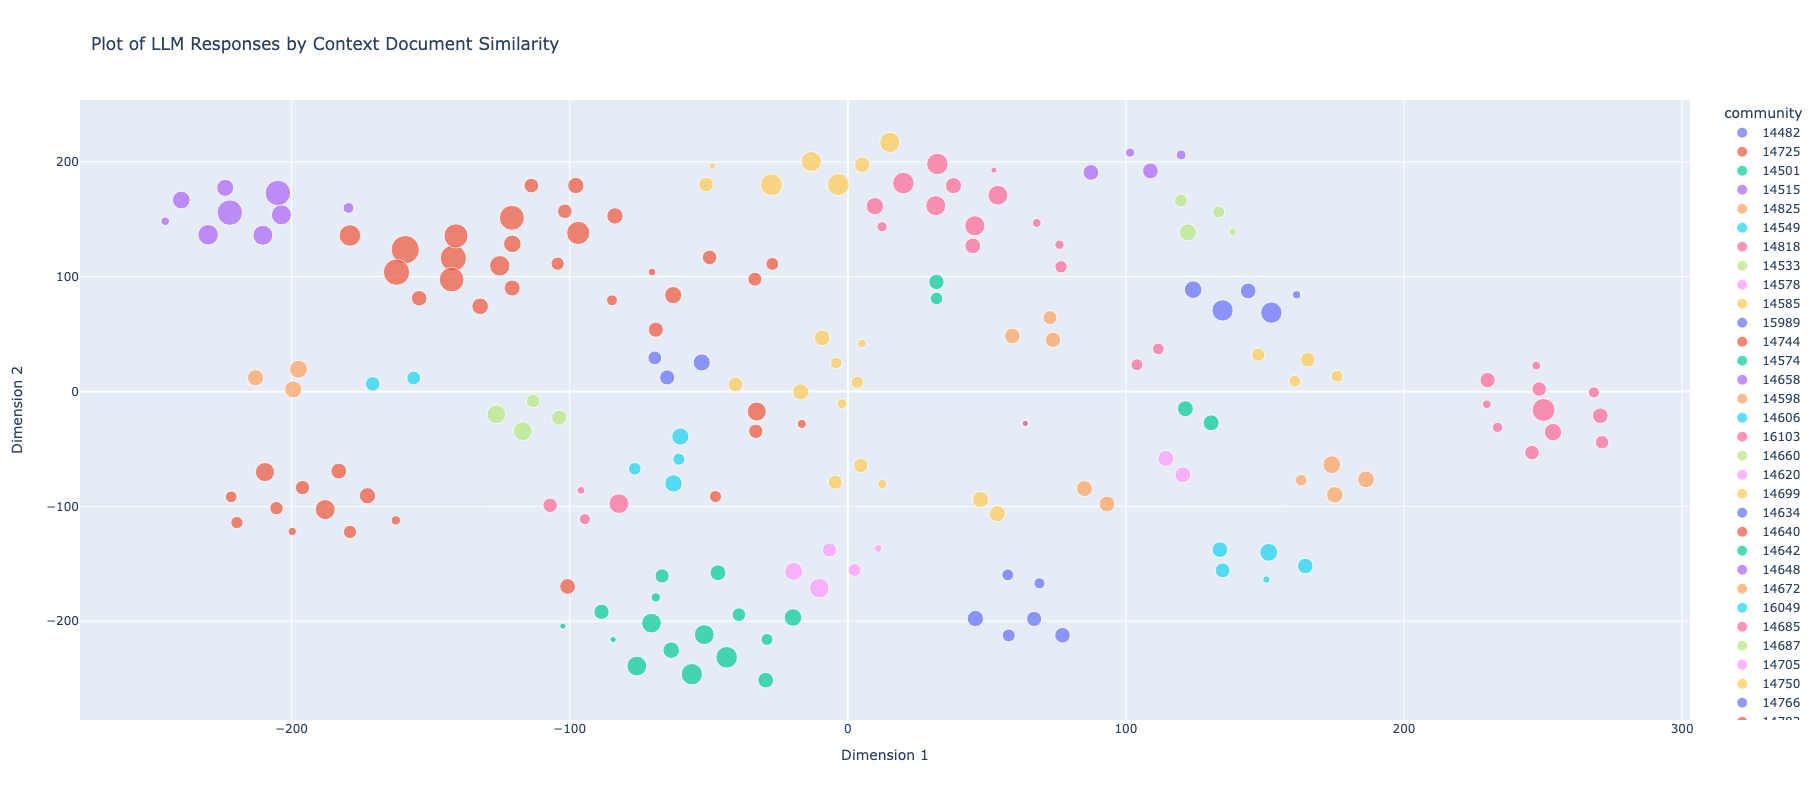

In [567]:
# plot the results 
plot_2d_embeddings(embedding_df=assistant_fastRP,
                   embeddings_col='fastRP',
                   labels_col='community',
                   size_col='pageRank',
                   plot_title='Plot of LLM Responses by Context Document Similarity')

### Analyze Assistant Message Communities
Also as before, we will generate additional statistics to help us understand the contents of each of the communities identified above.

In [596]:
# query for assistant message details in a new dataframe 
response_community_df = gds.run_cypher('''
MATCH (a:Assistant)
RETURN
    a.id AS id,
    a.numDocs AS numDocs,
    a.responseCommunity AS community,
    a.similarityPR AS pageRank,
    a.rating AS rating,
    a.content AS content
''')

response_community_df.shape

(205, 6)

In [597]:
# create textLen and wordCount features 
response_community_df['textLen'] = response_community_df['content'].apply(len)
response_community_df['wordCount'] = response_community_df['content'].str.split().apply(len)

In [598]:
# fill missing and None values 
response_community_df['numDocs'].fillna(0, inplace=True)
response_community_df['rating'].fillna('NotRated', inplace=True)

In [599]:
# convert community feature to string 
response_community_df['community'] = response_community_df['community'].astype(str)

In [600]:
# expand rating to dummy values 
response_community_df = pd.get_dummies(data=response_community_df, columns=['rating'])

In [613]:
# response_community_df.head(2)

In [608]:
response_community_agg_df = (
     response_community_df[['id', 'numDocs', 'community', 'pageRank', 'textLen', 'wordCount', 'rating_Bad', 'rating_Good', 'rating_NotRated']]
        .groupby('community')
        .agg({
            'id': 'count',
            'numDocs': 'median',
            'pageRank': 'median',
            'textLen': 'median',
            'wordCount': 'median',
            'rating_Good': 'sum',
            'rating_Bad': 'sum',
            'rating_NotRated': 'sum' 
         })
)

# rename columns
response_community_agg_df.columns = ['size', 'med_numDocs', 'med_pageRank', 'med_textLen', 'med_wordCount', 'ratings_Good', 'ratings_Bad', 'NotRated']



# confirm dataframe shape
response_community_agg_df.shape

(57, 8)

In [609]:
# sort by community size 
response_community_agg_df.sort_values(by='size', ascending=False, inplace=True)

response_community_agg_df.head()

,size,med_numDocs,med_pageRank,med_textLen,med_wordCount,ratings_Good,ratings_Bad,NotRated
community,,,,,,,,
14725,25,6.0,1.009269,1911.0,246.0,15,2,8
14501,16,5.0,0.950335,2001.0,246.5,4,3,9
14699,14,10.0,0.862450,1778.0,219.5,6,2,6
14818,13,10.0,0.980136,1963.0,244.0,6,1,6
14685,11,10.0,0.800114,2089.0,246.0,5,4,2


In [618]:
# view responses from top community and with the highest pageRank scores
response_community_df[response_community_df['community'] == '14725'][['community', 'content', 'pageRank']].sort_values(by='pageRank', ascending=False).head()

,community,content,pageRank
91,14725,"Graph data science in Neo4j and PyTorch Geometric, while both powerful, have some distinct differences.\n\nNeo4j's Graph Data Science library is a comprehensive set of graph algorithms and an analytics platform that can efficiently handle large-scale data analysis. It is tightly integrated with the Cypher Query Language, which is powerful, intuitive, and optimized for graph data [1]. Neo4j also offers a Python client for their GDS library, allowing for the seamless execution of graph algorithms using Python code. This is particularly beneficial for integrating graph analytics into Python-based workflows [2]. \n\nNeo4j also stands out with its support for knowledge graphs, which are an effective tool for smart data management and analytics use-cases [1][2]. It further extends its capability with data connectors for Apache Kafka, Apache Spark, and various Business Intelligence tools, enabling a wider range of use-cases [1][2].\n\nOn the other hand, PyTorch Geometric (PyG) is a geometric deep learning extension library for PyTorch. It is primarily used for implementing geometric deep learning, graph neural networks, and similar techniques [3]. Unlike Neo4j, PyG is more focused on learning representations of graph-structured data using neural networks.\n\nIn conclusion, while both Neo4j and PyTorch Geometric are powerful tools in the field of graph data science, they serve different use-cases. Neo4j excels at large-scale graph data analysis, offering a comprehensive set of graph algorithms and a powerful query language, while PyTorch Geometric is more suited for graph-structured data learning using neural networks.\n\nUnfortunately, the context documents provided did not offer direct comparisons between Neo4j and PyTorch Geometric, and the AI used its knowledge and available resources to provide this answer.\n\nSources:\n[1] https://neo4j.com/developer-blog/gds-supply-chains-metrics-performance-python/\n[2] https://neo4j.com/developer-blog/get-started-with-neo4j-gds-python-client/\n[3] https://pytorch-geometric.readthedocs.io/",3.012911
95,14725,"As an experienced graph data scientist at Neo4j, I can say that PyTorch Geometric would be a better choice over Neo4j Graph Data Science (GDS) when dealing with tasks that require geometric deep learning, graph neural networks, or similar techniques. \n\nFrom the context documents you provided, it is clear that Neo4j GDS is very powerful when dealing with relational data and has a strong focus on graph algorithms for predictive analytics. There is a mention of graph neural networks in one of the documents [4], but the context suggests that this is more of an area for exploration rather than a ready-to-use feature. \n\nOn the other hand, PyTorch Geometric is a library specifically designed for geometric deep learning extensions and graph-based neural networks. It provides a wide range of tools and methods for machine learning tasks involving graph-structured data. \n\nSo, a use case where I would recommend PyTorch Geometric over Neo4j GDS would be a scenario that requires complex graph neural networks, such as predicting molecular properties, social network analysis with deep learning, or any situation where you need to learn representations of graph-structured data using neural networks. \n\nIn conclusion, the choice between Neo4j GDS and PyTorch Geometric would depend on the complexity of the tasks you need to perform on your graph-structured data and whether they involve deep learning.\n\nSources:\n[4] https://medium.com/neo4j/using-neo4j-graph-data-science-in-python-to-improve-machine-learning-models-c55a4e15f530\n",2.620587
92,14725,"As an experienced graph data scientist at Neo4j, deciding between Neo4j GDS, NetworkX, or PyTorch Geometric for a graph data science use case would depend on several factors. \n\nNeo4j's Graph Data Science (GDS) library is an excellent choice for large-scale data analysis tasks. It offers a comprehensive set of graph 

In [611]:
# sort by median PageRank
response_community_agg_df.sort_values(by='med_pageRank', ascending=False, inplace=True)
response_community_agg_df.head()

,size,med_numDocs,med_pageRank,med_textLen,med_wordCount,ratings_Good,ratings_Bad,NotRated
community,,,,,,,,
14515,9,6.0,1.512283,1757.0,228.0,1,1,7
14482,5,10.0,1.166840,1786.0,193.0,1,0,4
14825,3,10.0,1.111836,1918.0,218.0,0,0,3
16023,4,10.0,1.099434,1952.5,253.5,0,0,4
14672,4,5.5,1.059368,1644.5,214.0,3,1,0


In [612]:
# sort by Bad ratings
response_community_agg_df.sort_values(by='ratings_Bad', ascending=False, inplace=True)
response_community_agg_df.head()

,size,med_numDocs,med_pageRank,med_textLen,med_wordCount,ratings_Good,ratings_Bad,NotRated
community,,,,,,,,
14685,11,10.0,0.800114,2089.0,246.0,5,4,2
14501,16,5.0,0.950335,2001.0,246.5,4,3,9
14699,14,10.0,0.862450,1778.0,219.5,6,2,6
14725,25,6.0,1.009269,1911.0,246.0,15,2,8
16109,3,10.0,0.864688,1774.0,218.0,0,2,1
